# **Malaria Detection**

##<b>Problem Definition</b>
**The context:**
Malaria is a contagious disease caused by Plasmodium parasites that are transmitted to humans through the bites of infected female Anopheles mosquitoes. The parasites enter the blood and begin damaging red blood cells (RBCs) that carry oxygen, which can result in respiratory distress and other complications. The lethal parasites can stay alive for more than a year in a person’s body without showing any symptoms. Therefore, late treatment can cause complications and could even be fatal. Almost 50% of the world’s population is in danger from malaria. There were more than 247 million malaria cases and 619,000 malaria-related deaths reported over the world in 2021. Children under 5 years of age are the most vulnerable population group affected by malaria; in 2021 they accounted for 80% of all malaria deaths worldwide (1).
Traditional diagnosis of malaria in the laboratory requires careful inspection by an experienced professional to discriminate between healthy and infected red blood cells. It is a tedious, time-consuming process, and the diagnostic accuracy (which heavily depends on human expertise) can be adversely impacted by inter-observer variability.

An automated system can help with the early and accurate detection of malaria. Applications of automated classification techniques using Machine Learning (ML) and Artificial Intelligence (AI) have consistently shown higher accuracy than manual classification. It would therefore be highly beneficial.

**The objectives:**
To build an efficient computer vision model to detect malaria. The model should identify whether the image of a red blood cell is that of one infected with malaria or not and classify the same as parasitized or uninfected respectively.
This dataset consists of colored images of red blood cells that contain parasitized and uninfected instances, where:
●	The parasitized cells contain the Plasmodium parasite.
●	The uninfected cells are free of the Plasmodium parasites but could contain other impurities.

**The key questions:** <br>
Can an automated system effectively detect Plasmodium parasites from stained images?

**The problem formulation:**
Detect plasmodium infection using deep learning

## <b>Data Description </b>

There are a total of 24,958 train and 2,600 test images (colored) that we have taken from microscopic images. These images are of the following categories:<br>


**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>


## <b>Important Notes</b>

- This notebook can be considered a guide to refer to while solving the problem. The evaluation will be as per the Rubric shared for each Milestone. Unlike previous courses, it does not follow the pattern of the graded questions in different sections. This notebook would give you a direction on what steps need to be taken in order to get a viable solution to the problem. Please note that this is just one way of doing this. There can be other 'creative' ways to solve the problem and we urge you to feel free and explore them as an 'optional' exercise.

- In the notebook, there are markdowns cells called - Observations and Insights. It is a good practice to provide observations and extract insights from the outputs.

- The naming convention for different variables can vary. Please consider the code provided in this notebook as a sample code.

- All the outputs in the notebook are just for reference and can be different if you follow a different approach.

- There are sections called **Think About It** in the notebook that will help you get a better understanding of the reasoning behind a particular technique/step. Interested learners can take alternative approaches if they want to explore different techniques.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Aug  7 23:53:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    46W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


###<b> Mounting the Drive

In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Importing libraries required to load the data
import zipfile

import os

from PIL import Image

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

# To ignore warnings
import warnings

warnings.filterwarnings('ignore')

# Remove the limit from the number of displayed columns and rows. It helps to see the entire dataframe while printing it
pd.set_option("display.max_columns", None)

pd.set_option("display.max_rows", 200)

### <b>Loading libraries</b>

### <b>Let us load the data</b>

**Note:**
- You must download the dataset from the link provided on Olympus and upload the same on your Google drive before executing the code in the next cell.
- In case of any error, please make sure that the path of the file is correct as the path may be different for you.

In [ ]:
# Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/cell_images.zip'

# The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:

    zip_ref.extractall()

The extracted folder has different folders for train and test data which further contains the different sizes of images for parasitized and uninfected cells within the respective folder name.

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model.

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [ ]:
# Storing the path of the extracted "train" folder
train_dir = '/content/cell_images/train'

# Size of image so that each image has the same size
SIZE = 64

# Empty list to store the training images after they are converted to NumPy arrays
train_images = []

# Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels = []

In [ ]:
# We will run the same code for "parasitized" as well as "uninfected" folders within the "train" folder
for folder_name in ['/parasitized/', '/uninfected/']:

    # Path of the folder
    images_path = os.listdir(train_dir + folder_name)

    for i, image_name in enumerate(images_path):

        try:

            # Opening each image using the path of that image
            image = Image.open(train_dir + folder_name + image_name)

            # Resizing each image to (64, 64)
            image = image.resize((SIZE, SIZE))

            # Converting images to arrays and appending that array to the empty list defined above
            train_images.append(np.array(image))

            # Creating labels for parasitized and uninfected images
            if folder_name == '/parasitized':

                train_labels.append(1)

            else:

                train_labels.append(0)

        except Exception:

            pass

# Converting lists to arrays
train_images = np.array(train_images)

train_labels = np.array(train_labels)

In [ ]:
# Storing the path of the extracted "test" folder
test_dir = '/content/cell_images/test'

# Size of image so that each image has the same size (it must be same as the train image size)
SIZE = 64

# Empty list to store the testing images after they are converted to NumPy arrays
test_images = []

# Empty list to store the testing labels (0 - uninfected, 1 - parasitized)
test_labels = []

In [ ]:
# We will run the same code for "parasitized" as well as "uninfected" folders within the "test" folder
for folder_name in ['/parasitized/', '/uninfected/']:

    # Path of the folder
    images_path = os.listdir(test_dir + folder_name)

    for i, image_name in enumerate(images_path):

        try:
            # Opening each image using the path of that image
            image = Image.open(test_dir + folder_name + image_name)

            # Resizing each image to (64, 64)
            image = image.resize((SIZE, SIZE))

            # Converting images to arrays and appending that array to the empty list defined above
            test_images.append(np.array(image))

            # Creating labels for parasitized and uninfected images
            if folder_name == '/parasitized/':

                test_labels.append(1)

            else:

                test_labels.append(0)

        except Exception:

            pass

# Converting lists to arrays
test_images = np.array(test_images)

test_labels = np.array(test_labels)

###<b> Checking the shape of train and test images

In [ ]:
# Shape of images
np.shape(train_images)


(24958, 64, 64, 3)

In [ ]:
np.shape(test_images)

(2600, 64, 64, 3)

###<b> Checking the shape of train and test labels

In [ ]:
# Shape of labels
np.shape(train_labels)

(24958,)

In [ ]:
np.shape(test_labels)

(2600,)

***Observations and insights:***

- There 24,958 images in the train directory, each have 64 by 64 dimensions. . Each image has a label
- There are 2600 test images, each have 64 by 64 dimensions, and each test image has a label
- Both train and test images have are in 3 channel colors red green and blue

In [ ]:
# Try to normalize the train and test images by dividing it by 255 and convert them to float32 using astype function

train_images = train_images.astype('float32')/255
test_images = test_images.astype('float32')/255

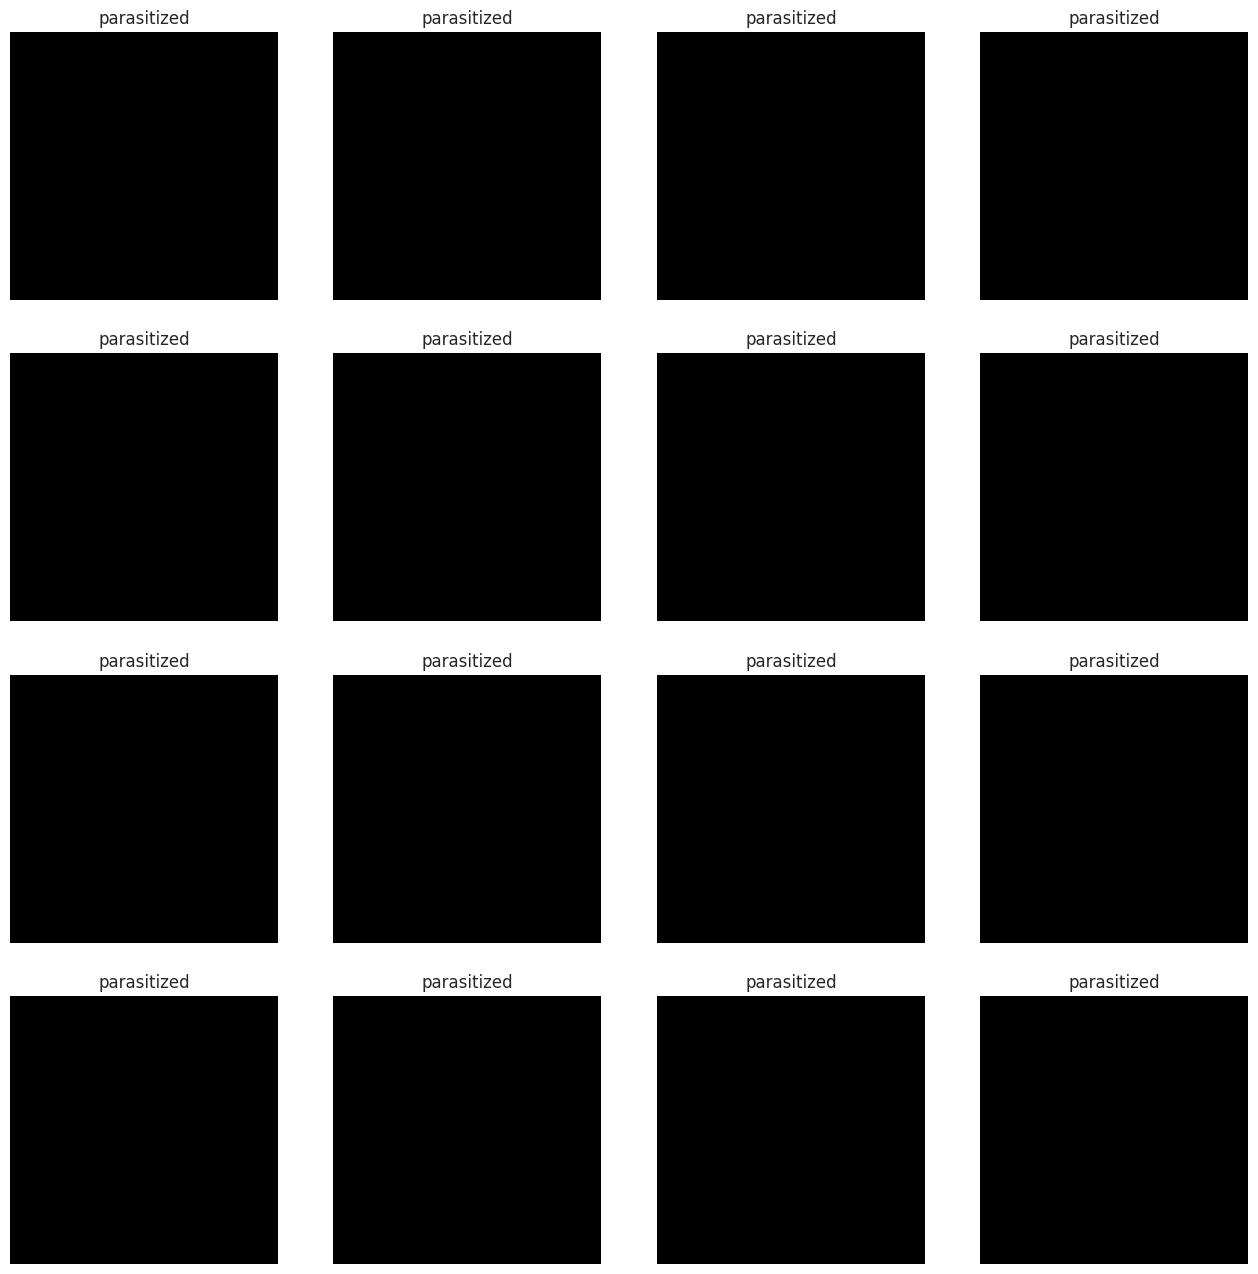

In [ ]:
# This code will help you in visualizing both the parasitized and uninfected images
np.random.seed(42)

plt.figure(1, figsize = (16 , 16))

for n in range(1, 17):

    plt.subplot(4, 4, n)

    index = int(np.random.randint(0, train_images.shape[0], 1))

    if train_labels[index] == 1:

        plt.title('parasitized')

    else:
        plt.title('uninfected')

    plt.imshow(train_images[index])

    plt.axis('off')

### <b>Check the minimum and maximum range of pixel values for train and test images

In [ ]:
# Try to use min and max function from numpy
minimum_train = np.amin(train_images, axis=(0, 1))
maximum_train = np.amax(train_images, axis=(0, 1))

minimum_train

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0

In [ ]:
maximum_train

array([[1.53787023e-05, 1.38106761e-05, 1.40519105e-05],
       [1.53787023e-05, 1.34488246e-05, 1.44740716e-05],
       [1.53787023e-05, 1.44137630e-05, 1.44740716e-05],
       [1.53787023e-05, 1.44137630e-05, 1.40519105e-05],
       [1.53787023e-05, 1.45343802e-05, 1.37503675e-05],
       [1.53787023e-05, 1.43534544e-05, 1.44137630e-05],
       [1.53787023e-05, 1.45343802e-05, 1.39312933e-05],
       [1.53787023e-05, 1.45946888e-05, 1.36900589e-05],
       [1.53787023e-05, 1.39312933e-05, 1.37503675e-05],
       [1.53787023e-05, 1.41725286e-05, 1.41725286e-05],
       [1.53787023e-05, 1.45343802e-05, 1.41122200e-05],
       [1.53787023e-05, 1.42328372e-05, 1.42931458e-05],
       [1.53787023e-05, 1.43534544e-05, 1.39312933e-05],
       [1.53787023e-05, 1.47153060e-05, 1.36900589e-05],
       [1.53787023e-05, 1.44137630e-05, 1.39916019e-05],
       [1.53787023e-05, 1.42931458e-05, 1.40519105e-05],
       [1.53787023e-05, 1.40519105e-05, 1.38709847e-05],
       [1.53787023e-05, 1.44137

In [ ]:
minimum_test = np.amin(test_images, axis=(0, 1))
maximum_test = np.amax(test_images, axis=(0, 1))

In [ ]:
minimum_test

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0

In [ ]:
maximum_test

array([[1.        , 0.8980392 , 0.8039216 ],
       [1.        , 0.85882354, 0.7921569 ],
       [1.        , 0.8980392 , 0.8352941 ],
       [1.        , 0.8901961 , 0.8235294 ],
       [1.        , 0.87058824, 0.8117647 ],
       [1.        , 0.8980392 , 0.827451  ],
       [1.        , 0.87058824, 0.81960785],
       [1.        , 0.8901961 , 0.81960785],
       [1.        , 0.8901961 , 0.8235294 ],
       [1.        , 0.8784314 , 0.8117647 ],
       [1.        , 0.89411765, 0.81960785],
       [1.        , 0.8784314 , 0.8156863 ],
       [1.        , 0.91764706, 0.83137256],
       [1.        , 0.8901961 , 0.827451  ],
       [1.        , 0.8784314 , 0.81960785],
       [1.        , 0.88235295, 0.8156863 ],
       [1.        , 0.9137255 , 0.81960785],
       [1.        , 0.88235295, 0.8156863 ],
       [1.        , 0.88235295, 0.83137256],
       [1.        , 0.9019608 , 0.8156863 ],
       [1.        , 0.90588236, 0.8235294 ],
       [1.        , 0.8745098 , 0.80784315],
       [1.

####<b> Observations and insights: ####

- Both the train and test images have a minimum range of zero pixels in all 3 color channels

- Both sets of images have maximum range of 255, 236 and 216 pixels in red, green and blue channels



###<b> Count the number of values in both uninfected and parasitized

In [ ]:
# Try to use value_counts to count the values
train_uninfected = os.path.join(train_dir, '/uninfected/')
train_parasitized = os.path.join(train_dir, '/parasitized/')

test_uninfected = os.path.join(test_dir, '/uninfected/')
test_parasitized = os.path.join(test_dir, '/parasitized/')

In [ ]:
import os

# folder path
uninfected_train_path = r'/content/cell_images/train/uninfected'
count = 0
# Iterate directory
for path in os.listdir(uninfected_train_path):
    if os.path.isfile(os.path.join(uninfected_train_path, path)):
       count += 1
uninfected_train_image_count = ('File count:', count)
print(uninfected_train_image_count)

('File count:', 12376)


In [ ]:
import os

# folder path
parasitized_train_path = r'/content/cell_images/train/parasitized'
count = 0
# Iterate directory
for path in os.listdir(parasitized_train_path):
    if os.path.isfile(os.path.join(parasitized_train_path, path)):
       count += 1
parasitized_train_image_count = ('File count:', count)
print(parasitized_train_image_count)

('File count:', 12582)


In [ ]:
import os

# folder path
uninfected_test_path = r'/content/cell_images/test/uninfected'
count = 0
# Iterate directory
for path in os.listdir(uninfected_test_path):
    if os.path.isfile(os.path.join(uninfected_test_path, path)):
       count += 1
print('File count:', count)

File count: 1300


In [ ]:
import os

# folder path
parasitized_test_path = r'/content/cell_images/test/parasitized'
count = 0
# Iterate directory
for path in os.listdir(parasitized_test_path):
    if os.path.isfile(os.path.join(parasitized_test_path, path)):
       count += 1
print('File count:', count)

File count: 1300


In [ ]:
from pandas import value_counts

In [ ]:
uninfected_value_counts = value_counts('uninfected')
print(uninfected_value_counts)

uninfected    10
dtype: int64


In [ ]:
value_counts(train_uninfected)

/uninfected/    12
dtype: int64

In [ ]:
value_counts(test_uninfected)

/uninfected/    12
dtype: int64

In [ ]:
parasitized_value_counts= value_counts('parasitized')
print(parasitized_value_counts)

parasitized    11
dtype: int64


In [ ]:
value_counts(train_uninfected)

/uninfected/    12
dtype: int64

In [ ]:
value_counts(test_uninfected)

/uninfected/    12
dtype: int64

###<b>Normalize the images

In [ ]:
# Try to normalize the train and test images by dividing it by 255 and convert them to float32 using astype function

train_images = train_images.astype('float32')/255
test_images = test_images.astype('float32')/255

####<b> Observations and insights: </b>

- There are 12376 uninfected images  and 12582 parasitized images in the train folder
- There 1300 images of uninfected and parasitized images in the test folder
- There 10 unique values in uninfected group, and 11 unique values in the parasitized group

###<b> Plot to check if the data is balanced

In [ ]:
# You are free to use bar plot or pie-plot or count plot, etc. to plot the labels of train and test data and check if they are balanced

print(train_labels.shape)
print(test_labels.shape)


(24958,)
(2600,)


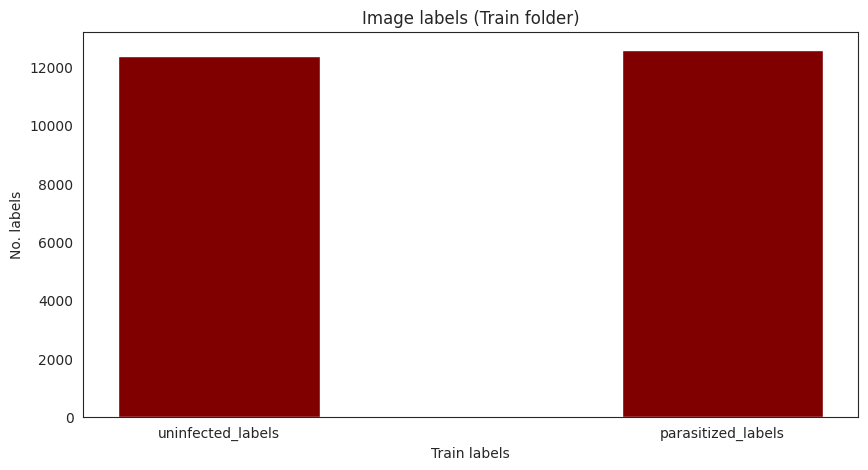

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

data = {'uninfected_labels':12376, 'parasitized_labels':12582}

image_labels = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(image_labels, values, color ='maroon',
        width = 0.4)

plt.xlabel("Train labels")
plt.ylabel("No. labels")
plt.title("Image labels (Train folder)")
plt.show()

In [ ]:
uninfected_counts = value_counts('uninfected')
parasitized_counts = value_counts('parasitized')

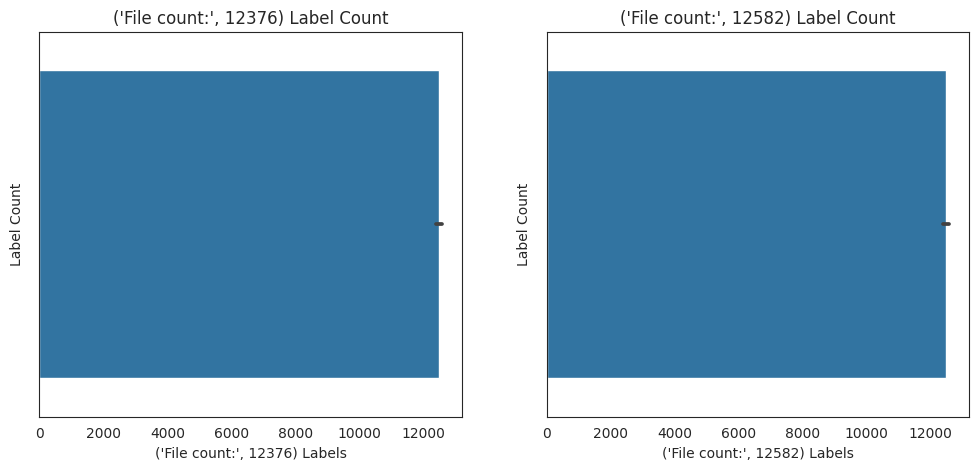

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
for idx, group in enumerate([(uninfected_train_image_count, train_labels), (parasitized_train_image_count, train_labels)]):
    data = train_labels
    sns.barplot(ax=ax[idx], x = np.arange(data.shape[0]))
    ax[idx].set_title(f'{group[0]} Label Count')
    ax[idx].set_xlabel(f'{group[0]} Labels')
    ax[idx].set_ylabel('Label Count')

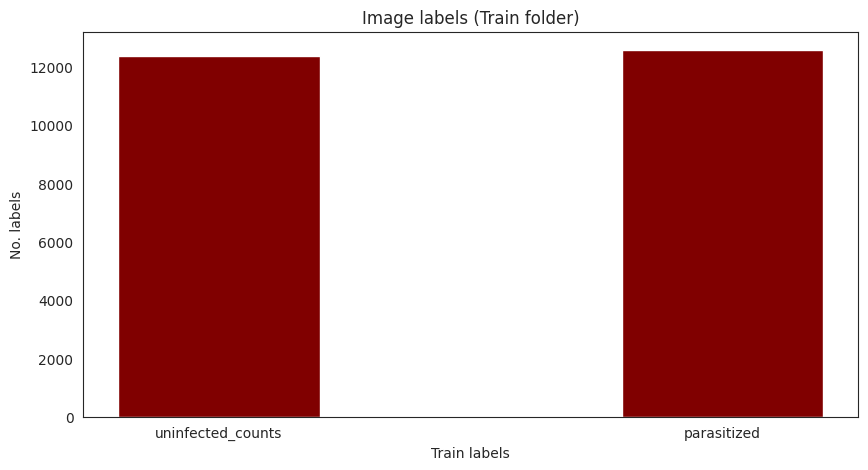

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

data = {'uninfected_counts':12376, 'parasitized':12582}

image_labels = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(image_labels, values, color ='maroon',
        width = 0.4)

plt.xlabel("Train labels")
plt.ylabel("No. labels")
plt.title("Image labels (Train folder)")
plt.show()

####<b> Observations and insights:</b>

- There are more images in the uninfected train folder than there are in the test folder


- test label data are balanced



### <b>Data Exploration</b>
Let's visualize the images from the train data

In [ ]:
import os

In [ ]:
# Parent directory where images are stored in drive
parent_dir = '/content/drive/MyDrive/cell_images'

# Path to the training and testing datasets within the parent directory
train_dir = os.path.join(parent_dir, 'train')
validation_dir = os.path.join(parent_dir, 'test')

# Directory with our training pictures
train_parasitized_dir = os.path.join(train_dir, 'parasitized')
train_no_dir = os.path.join(train_dir, 'uninfected')

# Directory with our testing pictures
validation_parasitized_dir = os.path.join(validation_dir, 'parasitized')
validation_no_dir = os.path.join(validation_dir, 'uninfected')

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
import matplotlib.image as mpimg

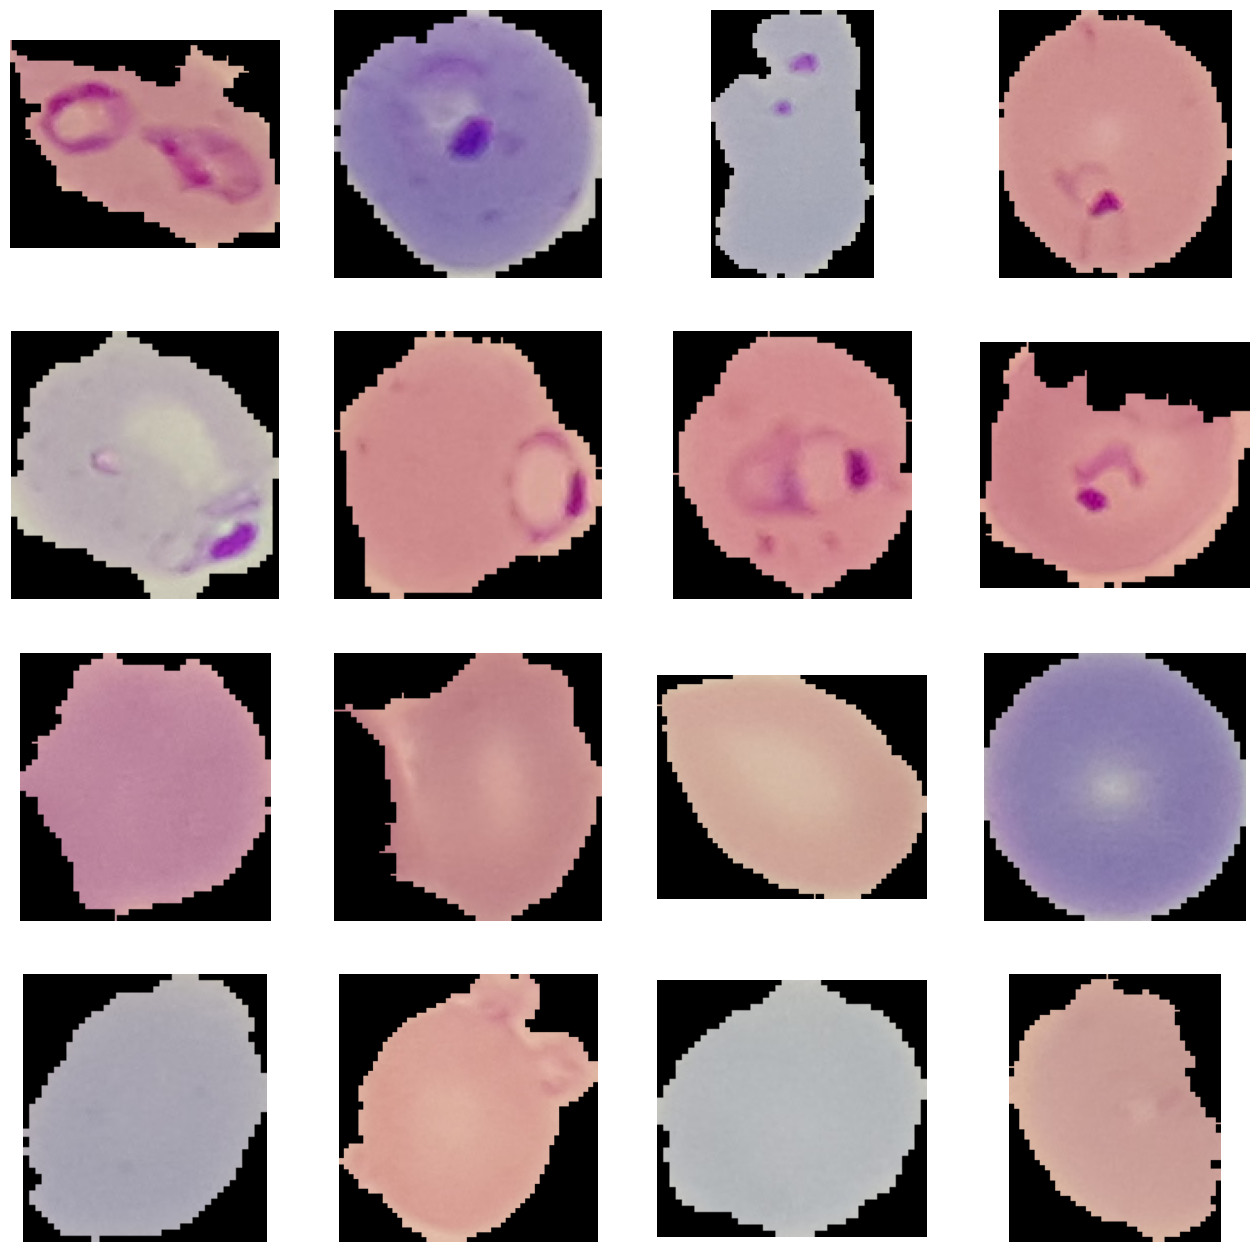

In [ ]:
train_parasitized_file_names = os.listdir(train_parasitized_dir)
train_no_file_names = os.listdir(train_no_dir)

fig = plt.figure(figsize=(16, 8))
fig.set_size_inches(16, 16)

parasitized_img_paths = [os.path.join(train_parasitized_dir, file_name) for file_name in train_parasitized_file_names[:8]]
no_img_paths = [os.path.join(train_no_dir, file_name) for file_name in train_no_file_names[:8]]

for i, img_path in enumerate(parasitized_img_paths + no_img_paths):
    ax = plt.subplot(4, 4, i + 1)
    ax.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

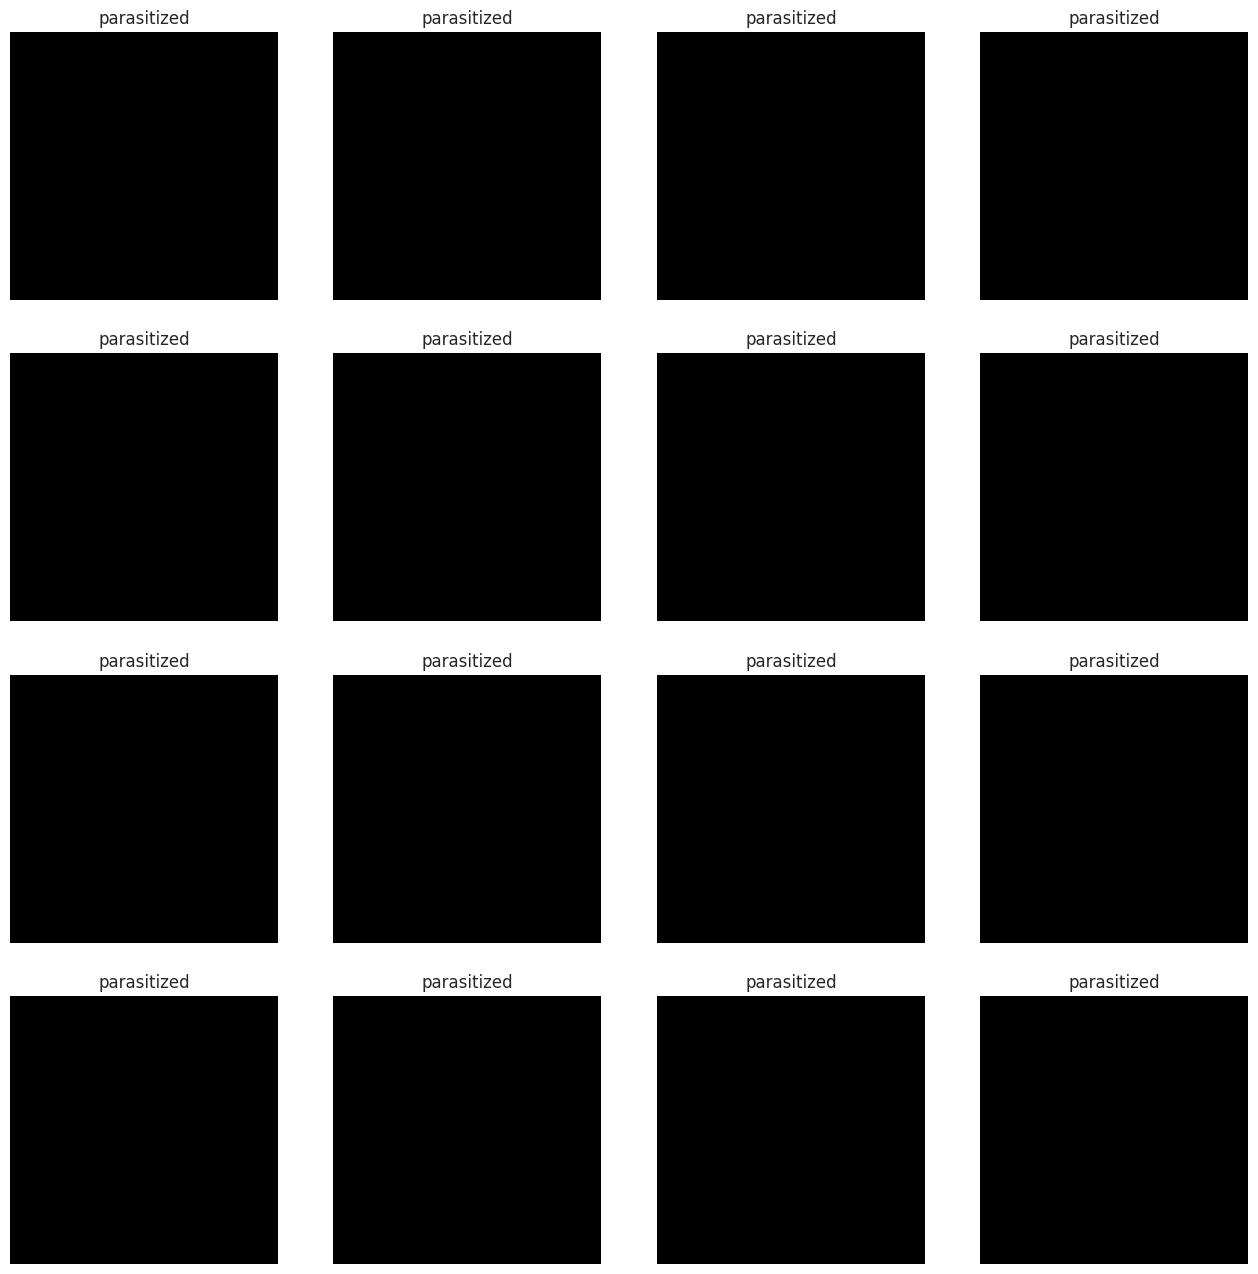

In [ ]:
# This code will help you in visualizing both the parasitized and uninfected images
np.random.seed(42)

plt.figure(1, figsize = (16 , 16))

for n in range(1, 17):

    plt.subplot(4, 4, n)

    index = int(np.random.randint(0, train_images.shape[0], 1))

    if train_labels[index] == 1:

        plt.title('parasitized')

    else:
        plt.title('uninfected')

    plt.imshow(train_images[index])

    plt.axis('off')

####<b> Observations and insights:

- All images labeled uninfected, however, there are clearly some parasitized samples
- Images are out of focus

###<b> Similarly visualize the images with subplot(6, 6) and figsize = (12, 12)

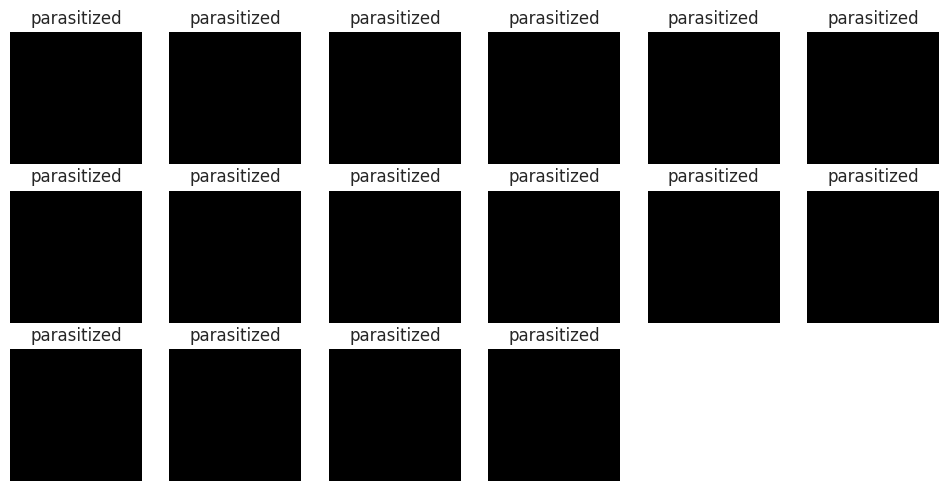

In [ ]:


plt.figure(1, figsize = (12 , 12))

for n in range(1, 17):

    plt.subplot(6, 6, n)

    index = int(np.random.randint(1, train_images.shape[0], 1))

    if train_labels[index] == 1:

        plt.title('parasitized')

    else:
        plt.title('uninfected')

    plt.imshow(train_images[index])

    plt.axis('off')

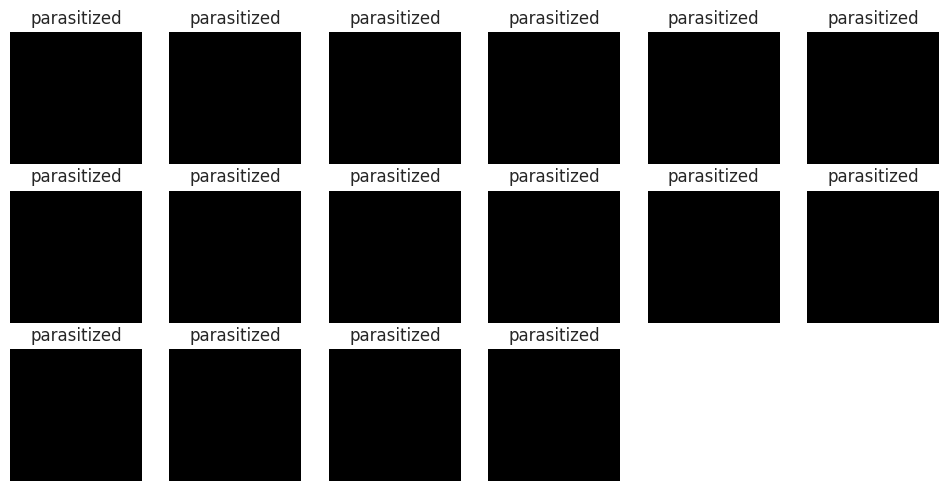

In [ ]:
# Hint: Have a keen look into the number of iterations that the for loop should iterate

np.random.seed(42)

plt.figure(1, figsize = (12 , 12))

for n in range(1, 17):

    plt.subplot(6, 6, n)

    index = int(np.random.randint(0, train_images.shape[0], 1))

    if train_labels[index] == 1:

        plt.title('parasitized')

    else:
        plt.title('uninfected')

    plt.imshow(train_images[index])

    plt.axis('off')

####<b>Observations and insights:


- All images labeled uninfected, however, there are clearly some parasitized samples
- Images are in focus

### <b> Data Exploration with labels

In [ ]:
root ='/content/cell_images/train'
inf = '/parasitized/'
un = '/uninfected/'

In [ ]:
Parasitized = os.listdir(root+inf)
Uninfected = os.listdir(root+un)

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
import cv2

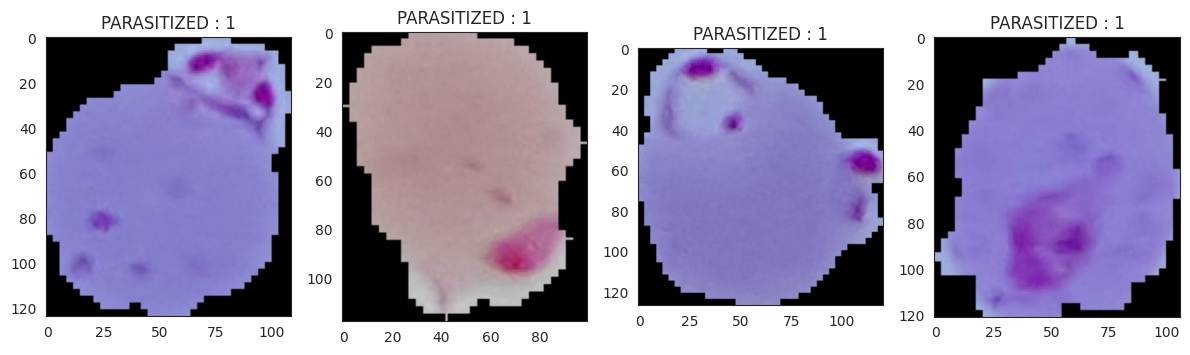

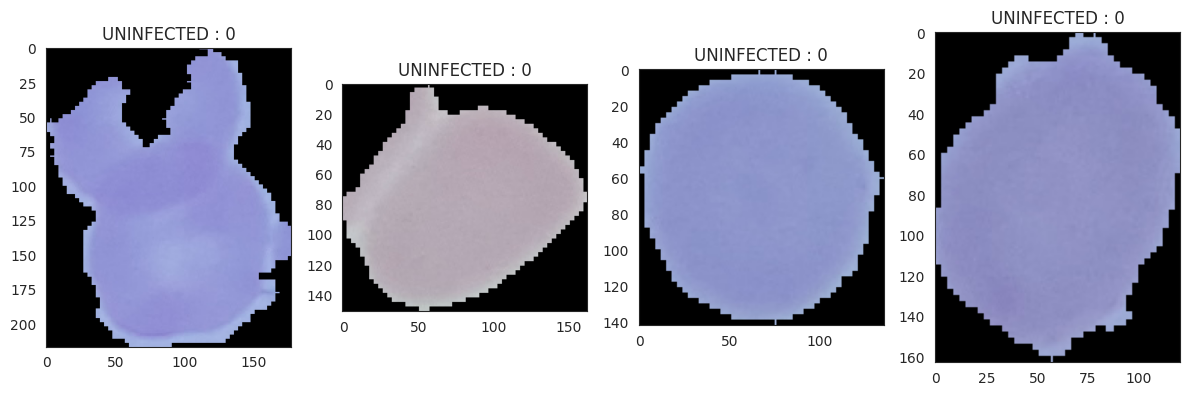

In [ ]:
# We previously had difficulty identifying uninfected and parasitized samples. Lets try this again
plt.figure(figsize = (12,24))
for i in range(4):
    plt.subplot(1, 4, i+1)
    img = cv2.imread(root+inf+ Parasitized[i])
    plt.imshow(img)
    plt.title('PARASITIZED : 1')
    plt.tight_layout()
plt.show()
plt.figure(figsize = (12,24))
for i in range(4):
    plt.subplot(2, 4, i+1)
    img = cv2.imread(root+un+ Uninfected[i+1])
    plt.imshow(img)
    plt.title('UNINFECTED : 0')
    plt.tight_layout()
plt.show()

### Observations

- We previously had trouble with identifying images in the training data. The above helps us selectand visualize bith parasitized and uninfected images


###<b> Plotting the mean images for parasitized and uninfected

<b> Mean image for parasitized and uninfected images

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array

data = []
labels = []
for img in Parasitized:
    try:
        img_read = plt.imread(root+inf+ img)
        img_resize = cv2.resize(img_read, (100, 100))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(1)
    except:
        None

for img in Uninfected:
    try:
        img_read = plt.imread(root+un+ img)
        img_resize = cv2.resize(img_read, (100, 100))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(0)
    except:
        None

### Mean uninfected

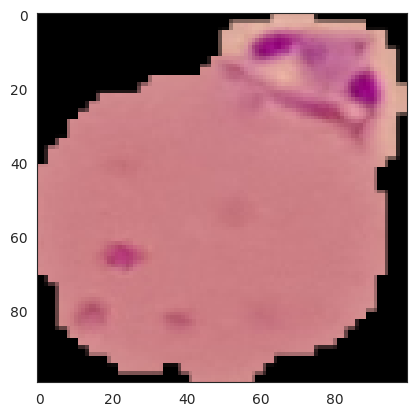

In [ ]:
plt.imshow(data[0])
plt.show()

### Mean Parasitized

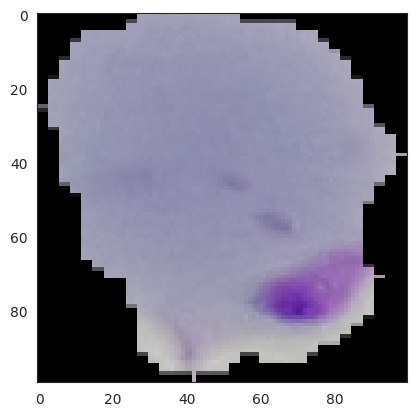

In [ ]:
plt.imshow(data[1])
plt.show()

####<b> Observations and insights: </b>

- Average parasitized and the average uninfected images look similar

- training is required to differ the two


### <b>Converting RGB to HSV of Images using OpenCV

###<b> Converting the train data

In [ ]:
import cv2

gfx=[]   # to hold the HSV image array

for i in np.arange(0, 100, 1):

  a = cv2.cvtColor(train_images[i], cv2.COLOR_BGR2HSV)

  gfx.append(a)

gfx = np.array(gfx)

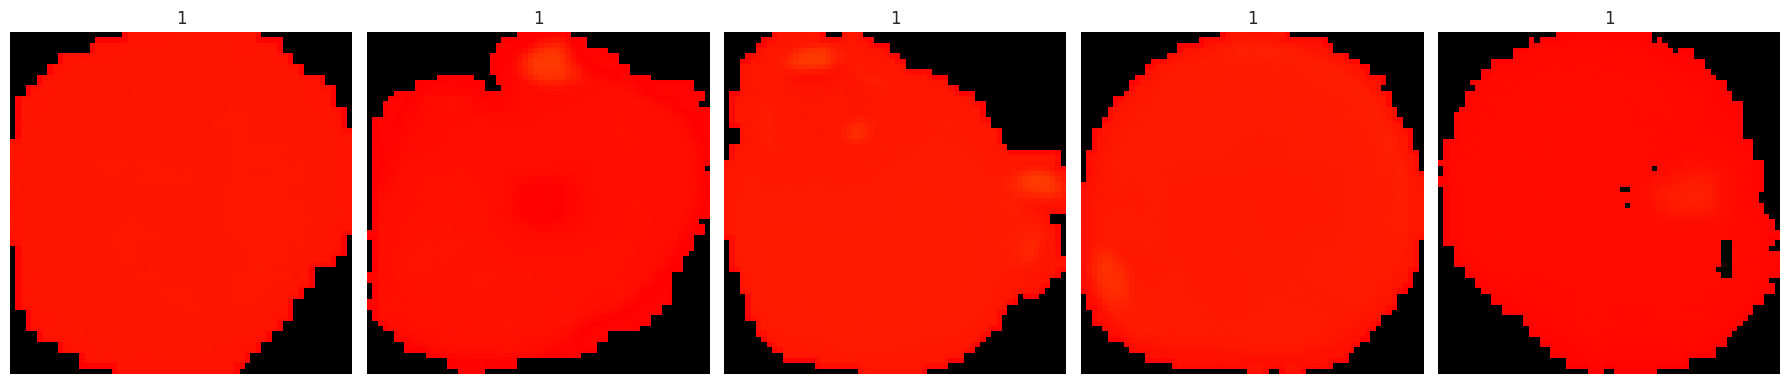

In [ ]:
viewimage = np.random.randint(1, 100, 5)

fig, ax = plt.subplots(1, 5, figsize = (18, 18))

for t, i in zip(range(5), viewimage):

  Title = train_labels[i]

  ax[t].set_title(Title)

  ax[t].imshow(gfx[i])

  ax[t].set_axis_off()

  fig.tight_layout()

###<b> Converting the test data

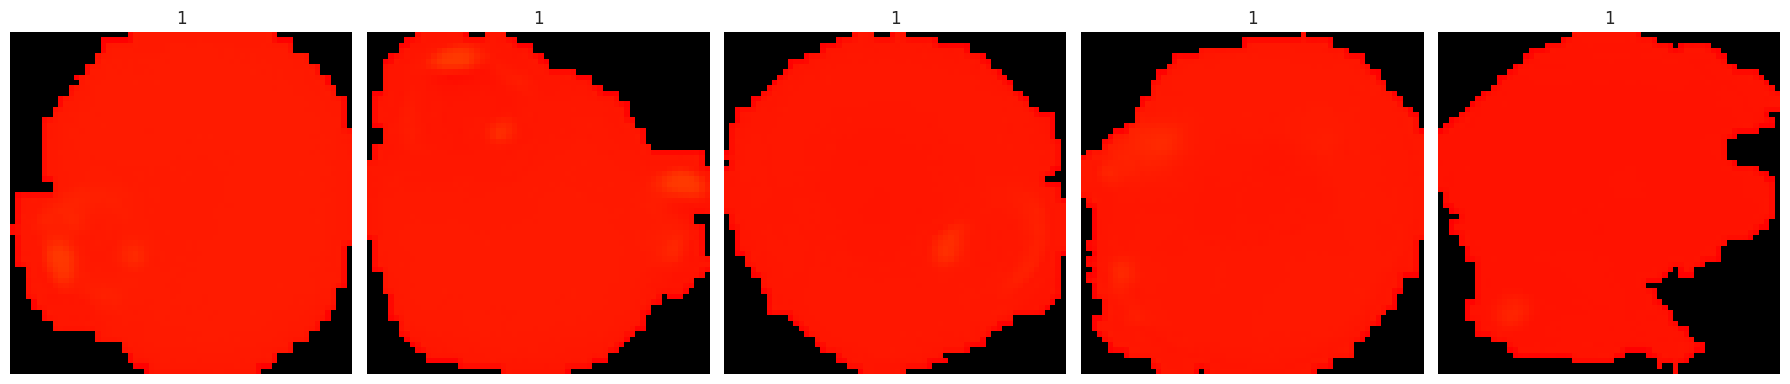

In [ ]:
# Similarly you can visualize for the images in the test data
viewimage = np.random.randint(1, 100, 5)

fig, ax = plt.subplots(1, 5, figsize = (18, 18))

for t, i in zip(range(5), viewimage):

  Title = test_labels[i]

  ax[t].set_title(Title)

  ax[t].imshow(gfx[i])

  ax[t].set_axis_off()

  fig.tight_layout()

####<b>Observations and insights:

- All Images have a purple hue with this command after changing the images from RGB to HSV
- separate images selected for train and test data

###<b> Processing Images using Gaussian Blurring

###<b> Gaussian Blurring on train data

In [ ]:
gbx = []  # To hold the blurred images

for i in np.arange(0, 100, 1):

  b = cv2.GaussianBlur(train_images[i], (5, 5), 0)

  gbx.append(b)

gbx = np.array(gbx)

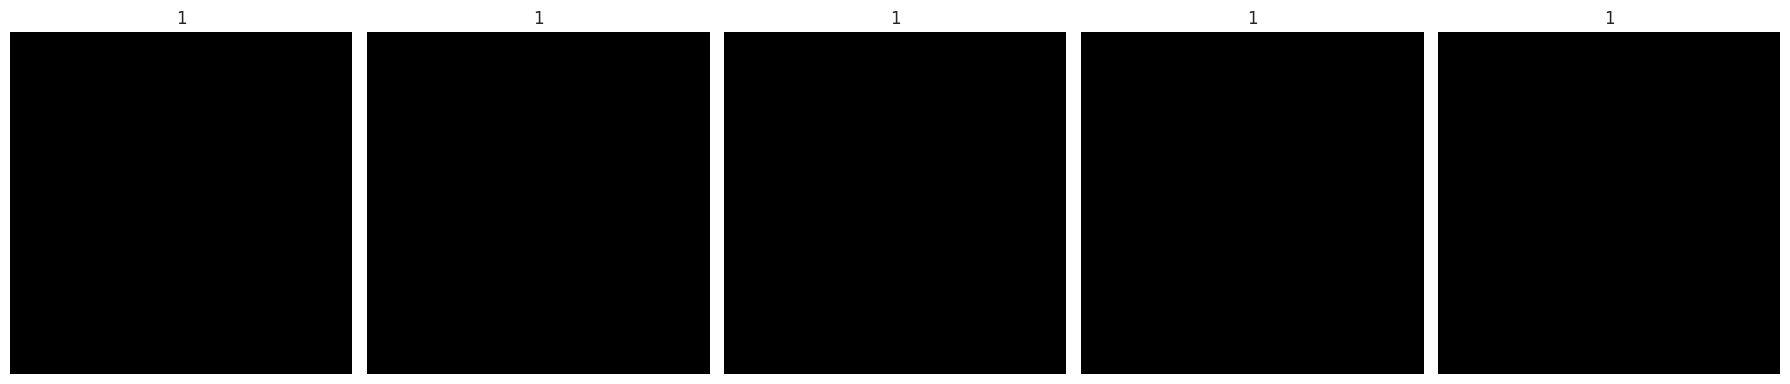

In [ ]:
viewimage = np.random.randint(1, 100, 5)

fig, ax = plt.subplots(1, 5, figsize = (18, 18))

for t, i in zip(range(5), viewimage):

  Title = train_labels[i]

  ax[t].set_title(Title)


  ax[t].imshow(gbx[i])

  ax[t].set_axis_off()

  fig.tight_layout()

###<b> Gaussian Blurring on test data

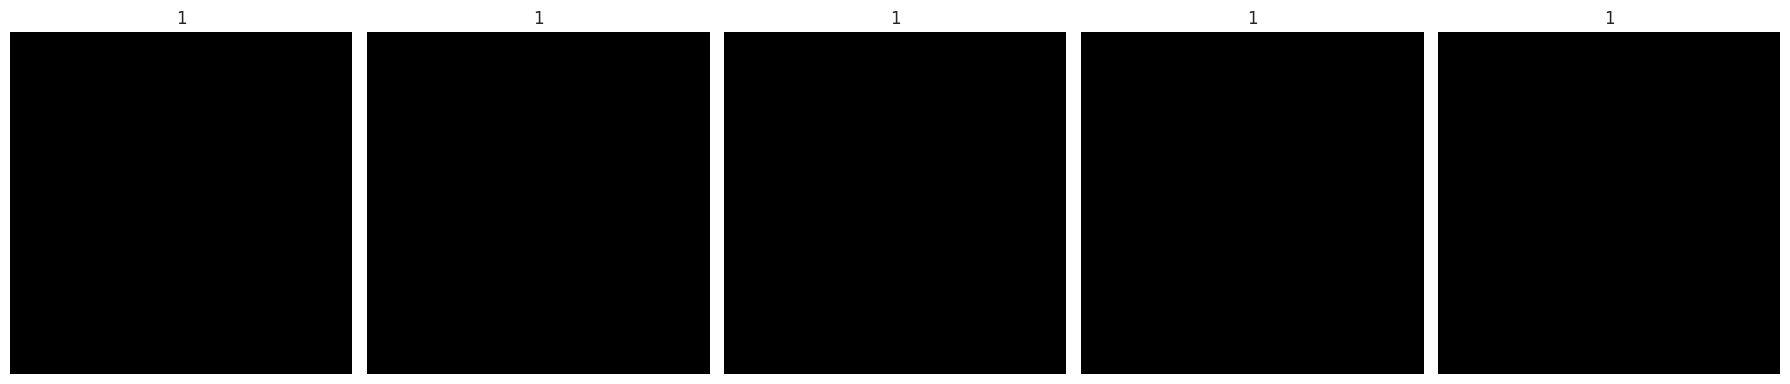

In [ ]:
# Similarly you can apply Gaussian blurring for the images in the test data
viewimage = np.random.randint(1, 100, 5)

fig, ax = plt.subplots(1, 5, figsize = (18, 18))

for t, i in zip(range(5), viewimage):

  Title = test_labels[i]

  ax[t].set_title(Title)


  ax[t].imshow(gbx[i])

  ax[t].set_axis_off()

  fig.tight_layout()

####**Observations and insights: **

**Think About It:** Would blurring help us for this problem statement in any way? What else can we try?

- Blurring does not assist us with this training the model - no image difference between parasitized and uninfected
- deeplearning neural network couldhelp identify the differences parsitized and uninfected

## <b> 1st Deep Learning Model

In [ ]:
from sklearn.utils import shuffle
from random import shuffle
image_data = np.array(data)
labels = np.array(labels)
idx = np.arange(image_data.shape[0])
np.random.shuffle(idx)
image_data = image_data[idx]
labels = labels[idx]

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
def prep_dataset(X,y):

    X_prep = X.astype('float32')/255
    y_prep = to_categorical(np.array(y))
    return (X_prep, y_prep)

In [ ]:
X_tr, X_ts, Y_tr, Y_ts = train_test_split(image_data,labels, test_size=0.15, shuffle=True,stratify=labels,random_state=42)

In [ ]:
X_ts, X_val, Y_ts, Y_val = train_test_split(X_ts,Y_ts, test_size=0.5, stratify=Y_ts,random_state=42)

In [ ]:
X_tr, Y_tr = prep_dataset(X_tr,Y_tr)

In [ ]:
X_val, Y_val = prep_dataset(X_val,Y_val)

In [ ]:
X_ts, _ = prep_dataset(X_ts,Y_ts)

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model = models.Sequential()
#Input + Conv 1 + ReLU + Max Pooling
model.add(layers.Conv2D(32,(5,5),activation='relu',padding='same',input_shape=X_tr.shape[1:]))
model.add(layers.MaxPool2D(strides=4))
model.add(layers.BatchNormalization())
# Conv 2 + ReLU + Max Pooling
model.add(layers.Conv2D(64,(5,5),padding='same',activation='relu'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())
# Conv 3 + ReLU + Max Pooling
model.add(layers.Conv2D(128,(3,3),padding='same',activation='relu'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())
# Conv 4 + ReLU + Max Pooling
model.add(layers.Conv2D(256,(3,3),dilation_rate=(2,2),padding='same',activation='relu'))
model.add(layers.Conv2D(256,(3,3),activation='relu'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())
# Fully Connected + ReLU
model.add(layers.Flatten())
model.add(layers.Dense(300, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
#Output
model.add(layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 25, 25, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                        

In [ ]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy',mode='max',patience=3,verbose=1)
history= model.fit(X_tr,Y_tr,
                 epochs=20,
                 batch_size=50,
                 validation_data=(X_val,Y_val),
                 callbacks=[es])

Epoch 1/20
425/425 [==============================] - 8s 9ms/step - loss: 0.2728 - accuracy: 0.8756 - val_loss: 2.0393 - val_accuracy: 0.4963
Epoch 2/20
425/425 [==============================] - 3s 8ms/step - loss: 0.0715 - accuracy: 0.9766 - val_loss: 0.0905 - val_accuracy: 0.9701
Epoch 3/20
425/425 [==============================] - 3s 8ms/step - loss: 0.0622 - accuracy: 0.9794 - val_loss: 0.0712 - val_accuracy: 0.9760
Epoch 4/20
425/425 [==============================] - 3s 8ms/step - loss: 0.0578 - accuracy: 0.9804 - val_loss: 0.0721 - val_accuracy: 0.9770
Epoch 5/20
425/425 [==============================] - 3s 8ms/step - loss: 0.0536 - accuracy: 0.9818 - val_loss: 0.0820 - val_accuracy: 0.9749
Epoch 6/20
425/425 [==============================] - 4s 9ms/step - loss: 0.0488 - accuracy: 0.9832 - val_loss: 0.0669 - val_accuracy: 0.9776
Epoch 7/20
425/425 [==============================] - 3s 8ms/step - loss: 0.0460 - accuracy: 0.9843 - val_loss: 0.0782 - val_accuracy: 0.9776
Epoch 

In [ ]:
import seaborn as sns

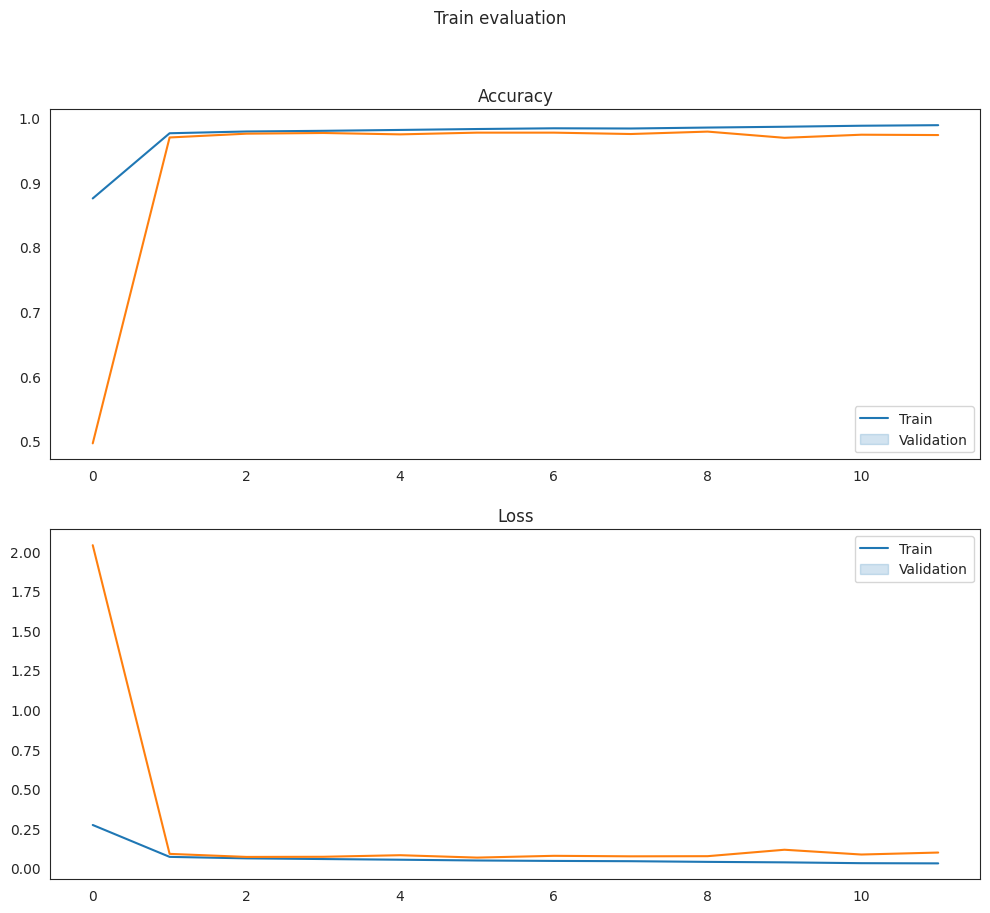

In [ ]:
fig, ax=plt.subplots(2,1,figsize=(12,10))
fig.suptitle('Train evaluation')
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['accuracy'])
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['val_accuracy'])
ax[0].legend(['Train','Validation'])
ax[0].set_title('Accuracy')
sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['val_loss'])
ax[1].legend(['Train','Validation'])
ax[1].set_title('Loss')
plt.show()

59/59 [==============================] - 0s 3ms/step


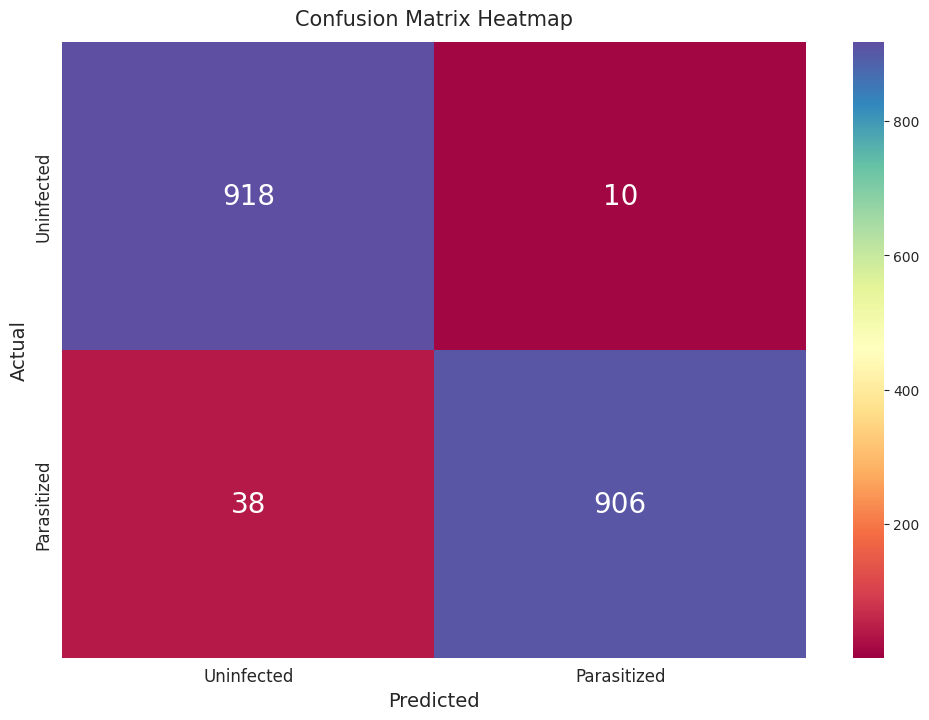

-Accuracy achieved: 97.44%
-Accuracy by model was: 98.91%
-Accuracy by validation was: 97.38%
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       928
           1       0.99      0.96      0.97       944

    accuracy                           0.97      1872
   macro avg       0.97      0.97      0.97      1872
weighted avg       0.97      0.97      0.97      1872



In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
Y_pred = model.predict(X_ts)
Y_pred = np.argmax(Y_pred, axis=1)
conf_mat = confusion_matrix(Y_ts,Y_pred)
sns.set_style(style='white')
plt.figure(figsize=(12,8))
heatmap = sns.heatmap(conf_mat,vmin=np.min(conf_mat.all()), vmax=np.max(conf_mat), annot=True,fmt='d', annot_kws={"fontsize":20},cmap='Spectral')
heatmap.set_title('Confusion Matrix Heatmap', fontdict={'fontsize':15}, pad=12)
heatmap.set_xlabel('Predicted',fontdict={'fontsize':14})
heatmap.set_ylabel('Actual',fontdict={'fontsize':14})
heatmap.set_xticklabels(['Uninfected','Parasitized'], fontdict={'fontsize':12})
heatmap.set_yticklabels(['Uninfected','Parasitized'], fontdict={'fontsize':12})
plt.show()
print('-Accuracy achieved: {:.2f}%\n-Accuracy by model was: {:.2f}%\n-Accuracy by validation was: {:.2f}%'.
      format(accuracy_score(Y_ts,Y_pred)*100,(history.history['accuracy'][-1])*100,(history.history['val_accuracy'][-1])*100))

from sklearn.metrics import classification_report

# Printing the classification report
print(classification_report(Y_ts, Y_pred))

####<b>Observations and insights: </b>
- Achieved an accuracy of 97.5%
- Accuracy and of the model were at 100%
- Accuracy and validation models were similar
-High precision, recall and f1 score for predicting both uninfected and parasitized images

## <b> Model_1


In [ ]:
from tensorflow.keras import backend
backend.clear_session()

In [ ]:

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from random import shuffle

In [ ]:
# Creating sequential model
model_1 = Sequential()

model_1.add(Conv2D(filters = 128, kernel_size = 2, padding = "same", activation = "relu", input_shape = (100,100, 3)))

model_1.add(MaxPooling2D(pool_size = 2))

model_1.add(Dropout(0.2))

model_1.add(Conv2D(filters = 64, kernel_size = 2, padding = "same", activation = "relu"))

model_1.add(MaxPooling2D(pool_size = 2))

model_1.add(Dropout(0.2))

model_1.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))

model_1.add(MaxPooling2D(pool_size = 2))

model_1.add(Dropout(0.2))

model_1.add(Flatten())

model_1.add(Dense(512, activation = "relu"))

model_1.add(Dropout(0.4))

model_1.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons

model_1.summary()


# Build the model here and add new layers


model_1.compile(loss="binary_crossentropy", optimizer="adam", metrics = ['accuracy'])


model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 128)     1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 50, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 25, 25, 64)        0

In [ ]:
model_1.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy',mode='max',patience=3,verbose=1)
history_1= model.fit(X_tr,Y_tr,
                 epochs=20,
                 batch_size=50,
                 validation_data=(X_val,Y_val),
                 callbacks=[es])

Epoch 1/20
425/425 [==============================] - 4s 9ms/step - loss: 0.0280 - accuracy: 0.9897 - val_loss: 0.0744 - val_accuracy: 0.9765
Epoch 2/20
425/425 [==============================] - 4s 8ms/step - loss: 0.0232 - accuracy: 0.9916 - val_loss: 0.1006 - val_accuracy: 0.9722
Epoch 3/20
425/425 [==============================] - 4s 9ms/step - loss: 0.0211 - accuracy: 0.9926 - val_loss: 0.0956 - val_accuracy: 0.9765
Epoch 4/20
425/425 [==============================] - 3s 8ms/step - loss: 0.0173 - accuracy: 0.9938 - val_loss: 0.0778 - val_accuracy: 0.9776
Epoch 5/20
425/425 [==============================] - 4s 9ms/step - loss: 0.0160 - accuracy: 0.9945 - val_loss: 0.0998 - val_accuracy: 0.9781
Epoch 6/20
425/425 [==============================] - 4s 9ms/step - loss: 0.0133 - accuracy: 0.9959 - val_loss: 0.1028 - val_accuracy: 0.9813
Epoch 7/20
425/425 [==============================] - 4s 9ms/step - loss: 0.0109 - accuracy: 0.9960 - val_loss: 0.1234 - val_accuracy: 0.9744
Epoch 

In [ ]:
def plot_accuracy(history_1):

    N = len(history_1.history["accuracy"])

    plt.figure(figsize = (12, 8))

    plt.plot(np.arange(0, N), history_1.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N), history_1.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")

    plt.xlabel("Epochs")

    plt.ylabel("Accuracy")

    plt.legend(loc="upper left")

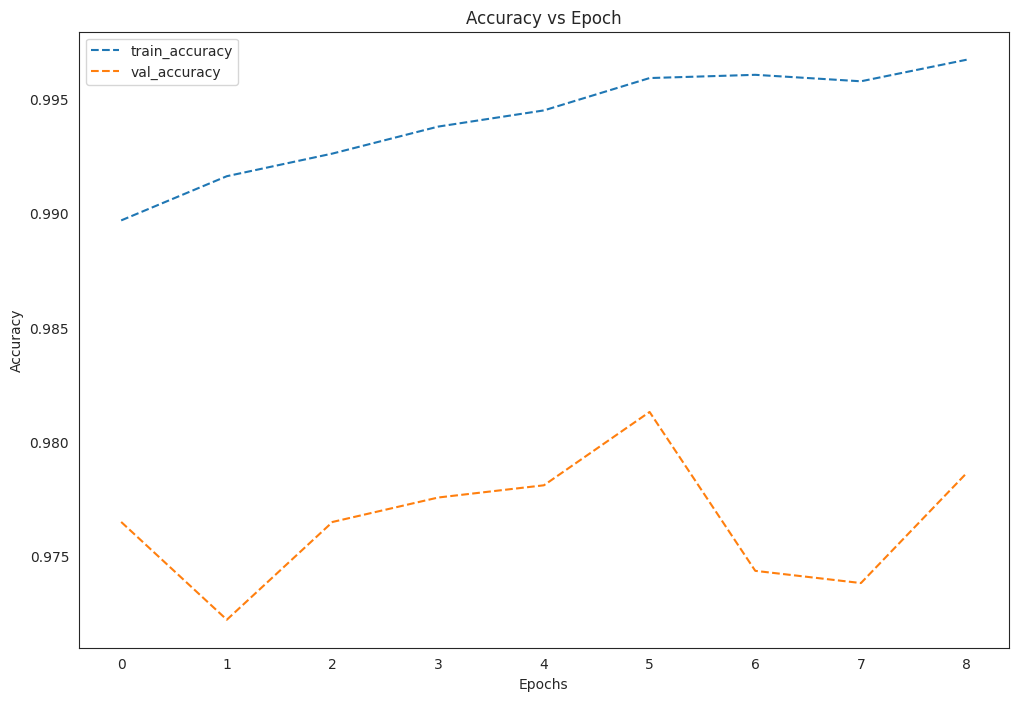

In [ ]:
plot_accuracy(history_1)

59/59 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.50      0.94      0.66       928
           1       0.62      0.09      0.16       944

    accuracy                           0.51      1872
   macro avg       0.56      0.52      0.41      1872
weighted avg       0.56      0.51      0.41      1872



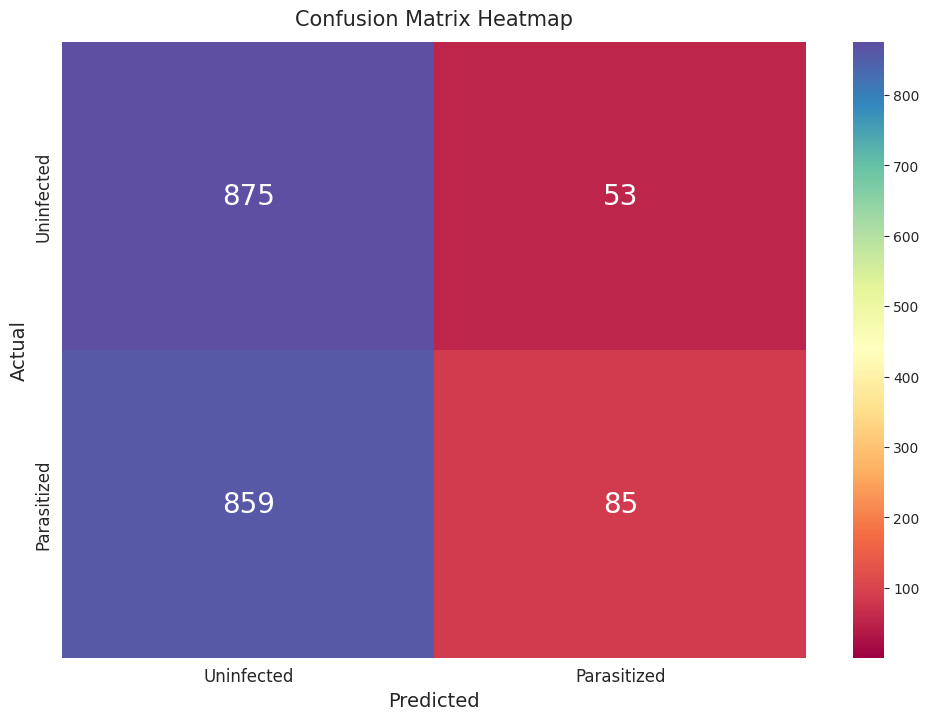

-Accuracy achieved: 51.28%
-Accuracy by model was: 99.67%
-Accuracy by validation was: 97.86%


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
Y_pred = model_1.predict(X_ts)
Y_pred = np.argmax(Y_pred, axis=1)
from sklearn.metrics import classification_report
# Printing the classification report
print(classification_report(Y_ts, Y_pred))
# Confusion matrix
conf_mat = confusion_matrix(Y_ts,Y_pred)
sns.set_style(style='white')
plt.figure(figsize=(12,8))
heatmap = sns.heatmap(conf_mat,vmin=np.min(conf_mat.all()), vmax=np.max(conf_mat), annot=True,fmt='d', annot_kws={"fontsize":20},cmap='Spectral')
heatmap.set_title('Confusion Matrix Heatmap', fontdict={'fontsize':15}, pad=12)
heatmap.set_xlabel('Predicted',fontdict={'fontsize':14})
heatmap.set_ylabel('Actual',fontdict={'fontsize':14})
heatmap.set_xticklabels(['Uninfected','Parasitized'], fontdict={'fontsize':12})
heatmap.set_yticklabels(['Uninfected','Parasitized'], fontdict={'fontsize':12})
plt.show()
print('-Accuracy achieved: {:.2f}%\n-Accuracy by model was: {:.2f}%\n-Accuracy by validation was: {:.2f}%'.
      format(accuracy_score(Y_ts,Y_pred)*100,(history_1.history['accuracy'][-1])*100,(history_1.history['val_accuracy'][-1])*100))

## <b> Model_2

In [ ]:
backend.clear_session()

In [ ]:
from keras.layers import BatchNormalization, LeakyReLU

model_2 = Sequential()

model_2.add(Conv2D(32, (3, 3), padding = "same", input_shape = (100, 100, 3)))#Complete this model using BatchNormalization layers and by using LeakyRelu as the activation function

model_2.add(MaxPooling2D(pool_size = 2))

model_2.add(BatchNormalization(synchronized=True))
model_2.add(Conv2D(filters = 64, kernel_size = 2, padding = "same"))

model_2.add(LeakyReLU(alpha=0.05))

model_2.add(MaxPooling2D(pool_size = 2))
model_2.add(BatchNormalization(synchronized=True))
model_2.add(Dropout(0.2))

model_2.add(Conv2D(filters = 32, kernel_size = 2, padding = "same"))

model_2.add(LeakyReLU(alpha=0.05))

model_2.add(MaxPooling2D(pool_size = 2))
model_2.add(BatchNormalization(synchronized=True))
model_2.add(Dropout(0.2))

model_2.add(Flatten())

model_2.add(Dense(512))

model_2.add(LeakyReLU(alpha=0.05))

model_2.add(Dropout(0.4))

model_2.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons


model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 50, 50, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        8256      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 50, 50, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0

In [ ]:
model_2.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy',mode='max',patience=3,verbose=1)
history_2= model.fit(X_tr,Y_tr,
                 epochs=20,
                 batch_size=50,
                 validation_data=(X_val,Y_val),
                 callbacks=[es])

Epoch 1/20
425/425 [==============================] - 4s 10ms/step - loss: 0.0106 - accuracy: 0.9961 - val_loss: 0.1178 - val_accuracy: 0.9728
Epoch 2/20
425/425 [==============================] - 4s 9ms/step - loss: 0.0097 - accuracy: 0.9964 - val_loss: 0.1122 - val_accuracy: 0.9744
Epoch 3/20
425/425 [==============================] - 4s 9ms/step - loss: 0.0057 - accuracy: 0.9984 - val_loss: 0.1536 - val_accuracy: 0.9770
Epoch 4/20
425/425 [==============================] - 4s 9ms/step - loss: 0.0086 - accuracy: 0.9970 - val_loss: 0.1512 - val_accuracy: 0.9706
Epoch 5/20
425/425 [==============================] - 4s 9ms/step - loss: 0.0074 - accuracy: 0.9977 - val_loss: 0.1782 - val_accuracy: 0.9754
Epoch 6/20
425/425 [==============================] - 4s 9ms/step - loss: 0.0065 - accuracy: 0.9975 - val_loss: 0.1708 - val_accuracy: 0.9674
Epoch 6: early stopping


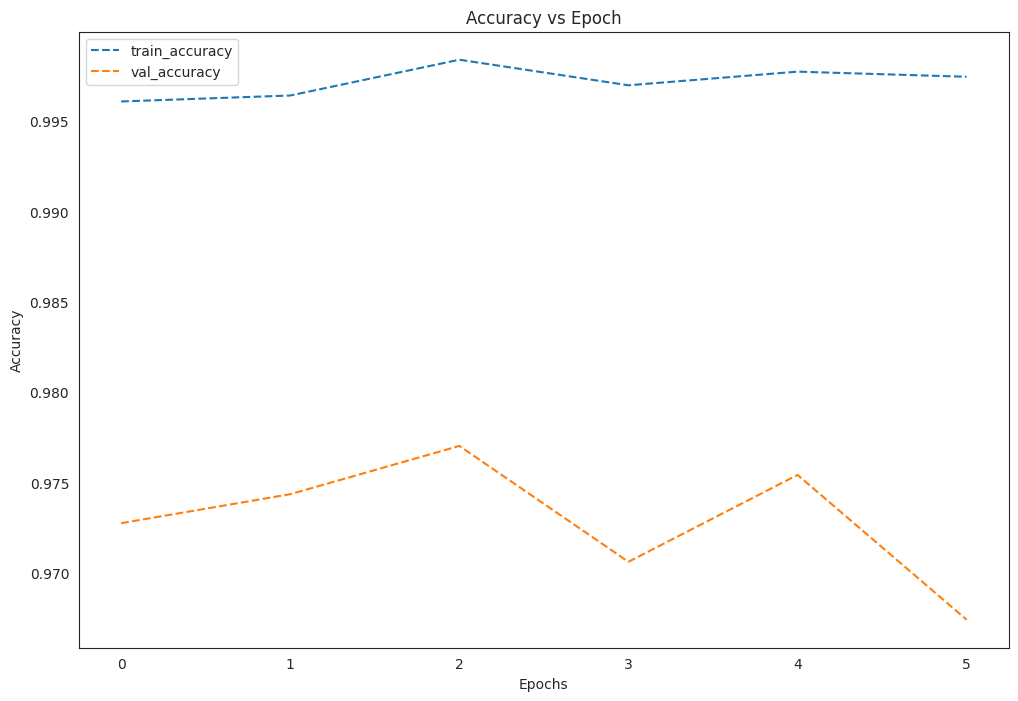

In [ ]:
def plot_accuracy(history_2):

    N = len(history_2.history["accuracy"])

    plt.figure(figsize = (12, 8))

    plt.plot(np.arange(0, N), history_2.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N), history_2.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")

    plt.xlabel("Epochs")

    plt.ylabel("Accuracy")

    plt.legend(loc="upper left")
plot_accuracy(history_2)

59/59 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.50      0.99      0.66       928
           1       0.44      0.00      0.01       944

    accuracy                           0.50      1872
   macro avg       0.47      0.50      0.33      1872
weighted avg       0.47      0.50      0.33      1872



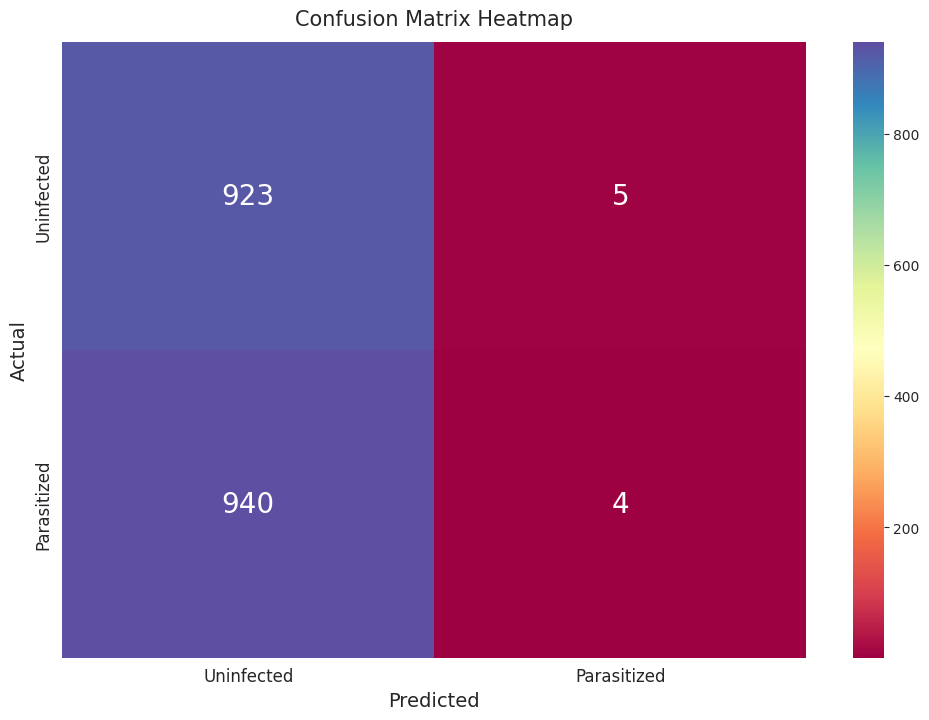

-Accuracy achieved: 49.52%
-Accuracy by model was: 99.75%
-Accuracy by validation was: 96.74%


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
Y_pred = model_2.predict(X_ts)
Y_pred = np.argmax(Y_pred, axis=1)
# Printing the classification report
print(classification_report(Y_ts, Y_pred))
# Confusion matrix
conf_mat = confusion_matrix(Y_ts,Y_pred)
sns.set_style(style='white')
plt.figure(figsize=(12,8))
heatmap = sns.heatmap(conf_mat,vmin=np.min(conf_mat.all()), vmax=np.max(conf_mat), annot=True,fmt='d', annot_kws={"fontsize":20},cmap='Spectral')
heatmap.set_title('Confusion Matrix Heatmap', fontdict={'fontsize':15}, pad=12)
heatmap.set_xlabel('Predicted',fontdict={'fontsize':14})
heatmap.set_ylabel('Actual',fontdict={'fontsize':14})
heatmap.set_xticklabels(['Uninfected','Parasitized'], fontdict={'fontsize':12})
heatmap.set_yticklabels(['Uninfected','Parasitized'], fontdict={'fontsize':12})
plt.show()
print('-Accuracy achieved: {:.2f}%\n-Accuracy by model was: {:.2f}%\n-Accuracy by validation was: {:.2f}%'.
      format(accuracy_score(Y_ts,Y_pred)*100,(history_2.history['accuracy'][-1])*100,(history_2.history['val_accuracy'][-1])*100))

####<b>Observations and insights:</b>

- Among the three models, the first model showed the most promise
- Accuracy fell to below 50% in the last two model swith the second model unable to correctly predict uninfected images while the third was unable to predict parasitized images. As such f1 scores for either uninfected or parasitized fell dramatically compared the first model
-First model fit well, the second model under fit while the third is underfit with some variability observed in model 2

In [ ]:
backend.clear_session()

<b> Generate the classification report and confusion matrix

###<b>Model 3 with Data Augmentation

In [ ]:
backend.clear_session() # Clearing backend for new model

###<b> Using image data generator

In [ ]:
from tensorflow.keras.utils import img_to_array, load_img

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images,train_labels, test_size=0.2,random_state=42)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using ImageDataGenerator to generate images
train_datagen = ImageDataGenerator(rescale=1.0/255.0,horizontal_flip = True,
                                  zoom_range = 0.5, rotation_range = 30, height_shift_range= 0.1, width_shift_range=0.1, shear_range = 0.1)

val_datagen  = ImageDataGenerator(rescale=1.0/255.0)

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow_from_directory(root, batch_size = 64, seed = 42, shuffle = True, class_mode='binary' )


# Flowing validation images using val_datagen generator
val_generator =  val_datagen.flow_from_directory(test_dir, batch_size = 64, seed = 42, shuffle = True, class_mode='binary')

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


###**Think About It :**<br>

*  Check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.



####<B>Visualizing Augmented images

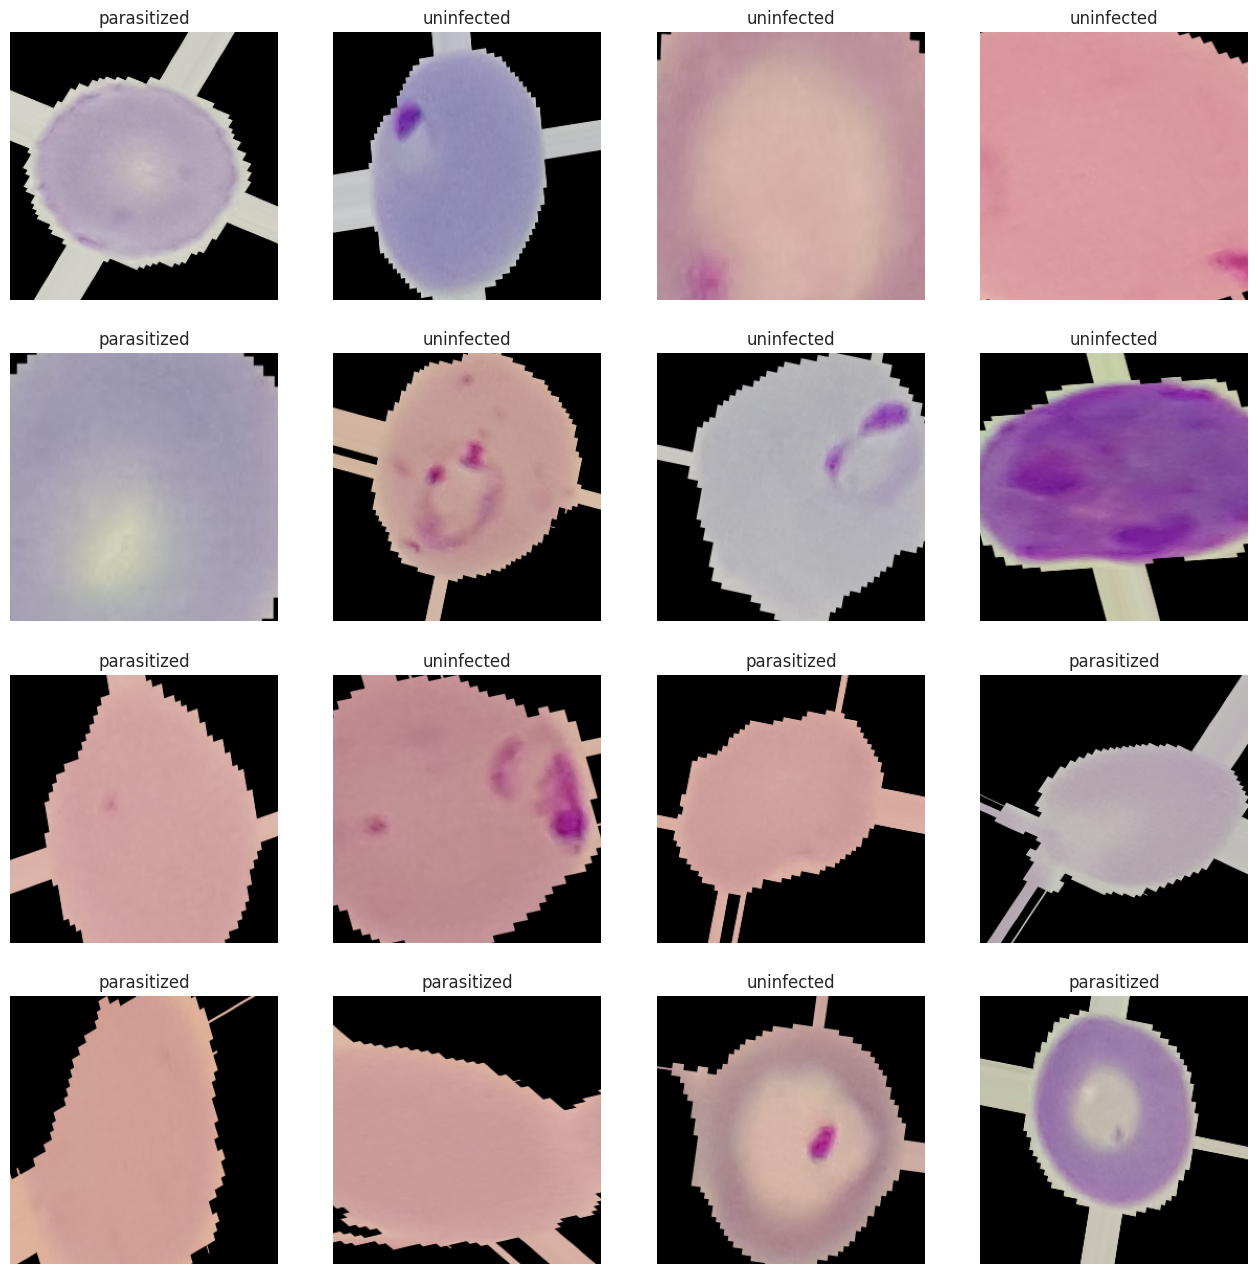

In [ ]:
# Creating an iterable for images and labels from the training data
images, labels = next(train_generator)

# Plotting 16 images from the training data
fig, axes = plt.subplots(4, 4, figsize = (16, 8))

fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):

    ax.imshow(image)

    if label == 1:

        ax.set_title('parasitized')

    else:

        ax.set_title('uninfected')

    ax.axis('off')

####<b>Observations and insights: </b>

- Using image data generator, we can now identify images that are parasitized and those that are uninfected
-Unfortunately, images are miscalled, it appears that a number of images that are labeled uninfected are actually parasitized (ring shape shape shows the parasite)., while several images labeled parsitized are actually uninfected
- Lets see next whether we can effectively predict parasitized images

###<b>Building the Model

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, LeakyReLU,Dropout


model3 = Sequential()

# Build the model here


model3.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), padding = 'same'))#Complete this model using BatchNormalization layers and by using LeakyRelu as the activation function

model3.add(MaxPooling2D(pool_size = 2))

model3.add(BatchNormalization(synchronized=True))
model3.add(Conv2D(filters = 64, kernel_size = 2, padding = "same"))

model3.add(LeakyReLU(alpha=0.05))

model3.add(MaxPooling2D(pool_size = 2))
model3.add(BatchNormalization(synchronized=True))
model3.add(Dropout(0.2))

model3.add(Conv2D(filters = 32, kernel_size = 2, padding = "same"))

model3.add(LeakyReLU(alpha=0.05))

model3.add(MaxPooling2D(pool_size = 2))
model3.add(BatchNormalization(synchronized=True))
model3.add(Dropout(0.2))

model3.add(Flatten())

model3.add(Dense(512))

model3.add(LeakyReLU(alpha=0.05))

model3.add(Dropout(0.4))

model3.add(Dense(1, activation = "sigmoid")) # 2 represents output layer neurons


model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        8256      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 64)      

## <b> Using Callbacks

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

In [ ]:
model3.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

history3= model3.fit(X_train,y_train,
                 epochs=20,
                 batch_size=50,
                 validation_data=(X_val,y_val),
                 callbacks=callbacks)

Epoch 1/20
400/400 [==============================] - 7s 9ms/step - loss: 0.0035 - accuracy: 0.9978 - val_loss: 9.0717e-09 - val_accuracy: 1.0000
Epoch 2/20
400/400 [==============================] - 3s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/20
400/400 [==============================] - 3s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/20
400/400 [==============================] - 3s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [ ]:
def plot_accuracy(history3):

    N = len(history3.history["accuracy"])

    plt.figure(figsize = (12, 8))

    plt.plot(np.arange(0, N), history3.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N), history3.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")

    plt.xlabel("Epochs")

    plt.ylabel("Accuracy")

    plt.legend(loc="upper left")

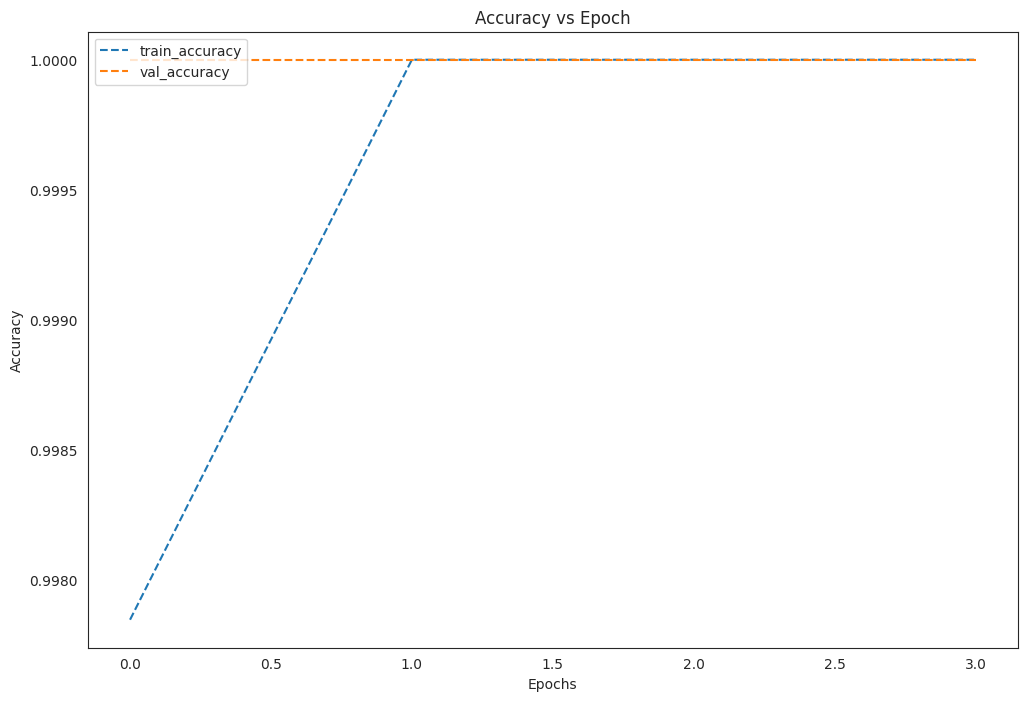

In [ ]:
# Plotting the loss vs epoch curve for the basic CNN model without Transfer Learning
plot_accuracy(history3)

In [ ]:
# Evaluating the model on test data

accuracy3 = model3.evaluate(test_images, test_labels, verbose = 1)

print('\n', 'Test_Accuracy:-', accuracy3[1])

82/82 [==============================] - 0s 3ms/step - loss: 350.2395 - accuracy: 0.5000

 Test_Accuracy:- 0.5


## Train another model


- Abnormal test accuracy - test accuracy is too accurate; may be an issue with th balance of image dat

<B>Plotting the classification report and confusion matrix

82/82 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1300
           1       0.00      0.00      0.00      1300

    accuracy                           0.50      2600
   macro avg       0.25      0.50      0.33      2600
weighted avg       0.25      0.50      0.33      2600



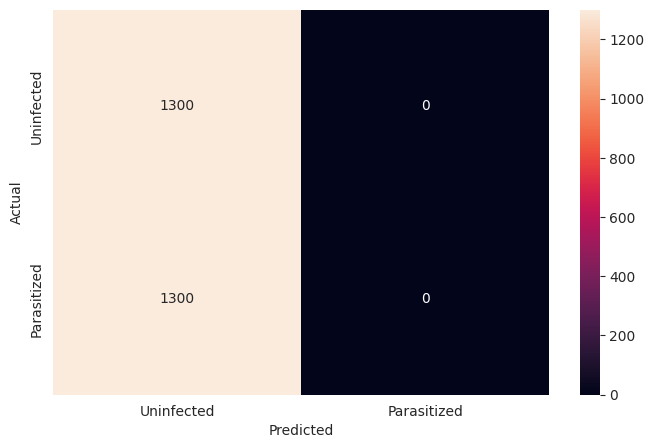

In [ ]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model3.predict(test_images)

pred = np.argmax(pred, axis = 1)

y_true = test_labels

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix

cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

<b> Now, let us try to use a pretrained model like VGG16 and check how it performs on our data.

### **Pre-trained model (VGG16)**

In [ ]:
backend.clear_session() # Clearing backend for new model

In [ ]:
import tensorflow as tf


# Clearing backend
from tensorflow.keras import backend

backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras import Model

vgg = VGG16(include_top = False, weights = 'imagenet', input_shape = (100,100, 3))

vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [ ]:
transfer_layer = vgg.get_layer('block5_pool')

vgg.trainable = False

# Add classification layers on top of it
x = Flatten()(transfer_layer.output)  # Flatten the output from the 3rd block of the VGG16 model

x = Dense(256, activation = 'relu')(x)

# Similarly add a dense layer with 128 neurons
x = Dropout(0.3)(x)

# Add a dense layer with 64 neurons

x = BatchNormalization()(x)

pred = Dense(2, activation = 'sigmoid')(x)

model4 = Model(vgg.input, pred) # Initializing the model

###<b>Compiling the model

In [ ]:
# Compiling the model
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0   

<b> using callbacks

In [ ]:
# Adding Callbacks to the model
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b>Fit and Train the model

In [ ]:
# Fitting the model and running the model for 10 epochs
history4 = model4.fit(
            X_tr,Y_tr,
            epochs = 10,
            callbacks = callbacks,
            batch_size = 50,
            validation_data =(X_ts,Y_ts))

Epoch 1/10
421/425 [============================>.] - ETA: 0s - loss: 0.7026 - accuracy: 0.5033

ValueError: ignored

<b>Plot the train and validation accuracy

In [ ]:
# Function to plot loss, val_loss,
def plot_history4(history4):
    N = len(history.history["accuracy"])
    plt.figure()
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy")
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="test_accuracy")
    plt.title("Training accuracy Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("accuracy")
    plt.legend(loc="upper right")

In [ ]:
# Plotting the loss vs epoch curve for the basic CNN model without Transfer Learning
plot_history4(model4)

In [ ]:
# plotting the accuracies
dict_hist = history4.history

list_ep = [i for i in range(0, 10)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

###**Observations and insights: **

*   Could not plot curves because no compiling could take place due to a graphics error

###<b> Evaluating the model

In [ ]:
# Evaluating the model on test data
accuracy4 = model4.evaluate(test_images, test_labels, verbose = 1)

print('\n', 'Test_Accuracy:-', accuracy4[1])

<b>Plotting the classification report and confusion matrix

In [ ]:
# Plot the confusion matrix and generate a classification report for the model
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model4.predict(test_images)

pred = np.argmax(pred, axis = 1)

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix

cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

## <b> Model 5

In [ ]:
backend.clear_session() # Clearing backend for new model

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size = 0.2, random_state = 42)



from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(rescale=1.0/ 255.0,
                              horizontal_flip = True,
                              vertical_flip = False,
                              height_shift_range= 0.1,
                              width_shift_range=0.1,
                              rotation_range=30,
                              shear_range = 0.1,
                              zoom_range=0.5)
test_datagen  = ImageDataGenerator(rescale = 1.0/255.0)

# Flowing training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(root,
                                                    batch_size=20,
                                                    class_mode='binary')

# Flowing testing images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(test_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary')

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


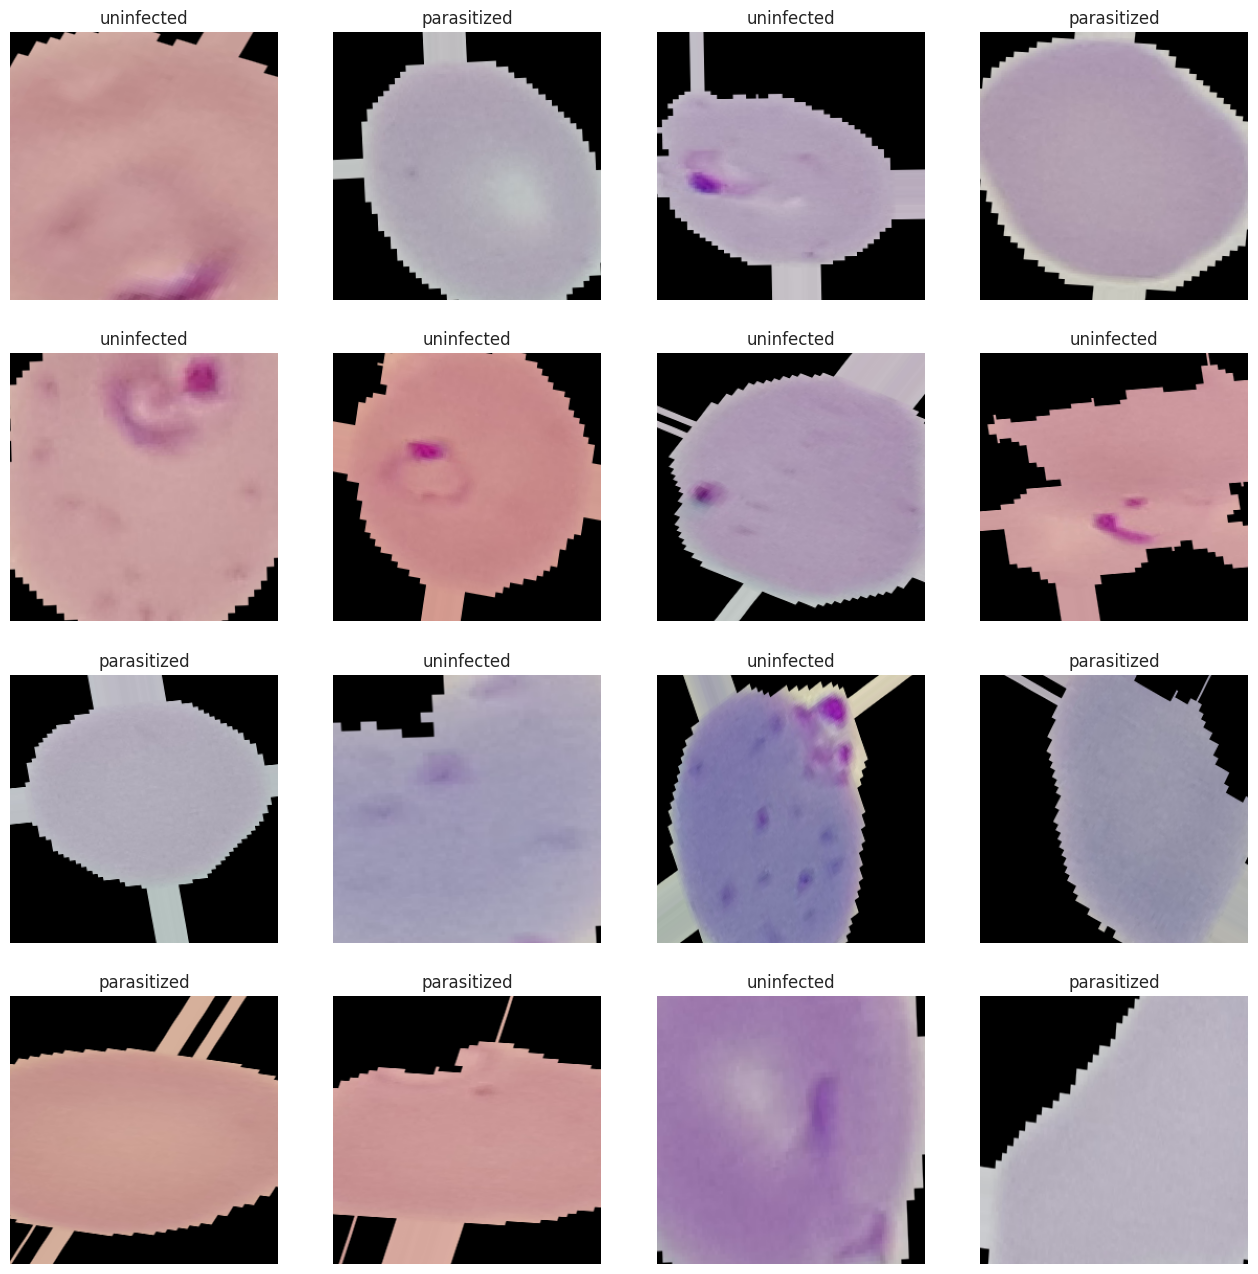

In [ ]:
# Creating an iterable for images and labels from the training data
images, labels = next(train_generator)

# Plotting 16 images from the training data
fig, axes = plt.subplots(4, 4, figsize = (16, 8))

fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):

    ax.imshow(image)

    if label == 1:

        ax.set_title('parasitized')

    else:

        ax.set_title('uninfected')

    ax.axis('off')

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

In [ ]:
model5 = Sequential()
model5.add(Conv2D(64, (3,3), activation='relu', input_shape=(100, 100, 3), padding = 'same'))
model5.add(MaxPooling2D(2,2))
model5.add(BatchNormalization())
model5.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
model5.add(MaxPooling2D(2,2))
model5.add(BatchNormalization())
model5.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
model5.add(MaxPooling2D(2,2))
model5.add(Conv2D(16, (3,3), activation='relu', padding = 'same'))
model5.add(Flatten())
model5.add(Dense(64, activation='relu'))
model5.add(Dropout(0.25))
model5.add(Dense(32, activation='relu'))
model5.add(Dropout(0.25))
model5.add(Dense(32, activation='relu'))
model5.add(Dense(1, activation='sigmoid'))

In [ ]:
model5.compile(loss="binary_crossentropy", optimizer="adam", metrics = ['accuracy'])
model5.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 100, 100, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 50, 50, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 50, 50, 32)        18464     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                      

In [ ]:
# Pulling a single large batch of random testing data for testing after each epoch
X_tr, Y_tr = validation_generator.next()

In [ ]:
# Adding Callbacks to the model
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

In [ ]:
model_history = model5.fit(train_generator,
                              val_generator,
                              batch_size = 50,
                              epochs=10,
                              callbacks = callbacks,
                              verbose=1)

ValueError: ignored

In [ ]:
# Evaluating on the Test dataset
model5.evaluate(validation_generator)

130/130 [==============================] - 3s 19ms/step - loss: 0.0609 - accuracy: 0.9785


[0.060909803956747055, 0.9784615635871887]

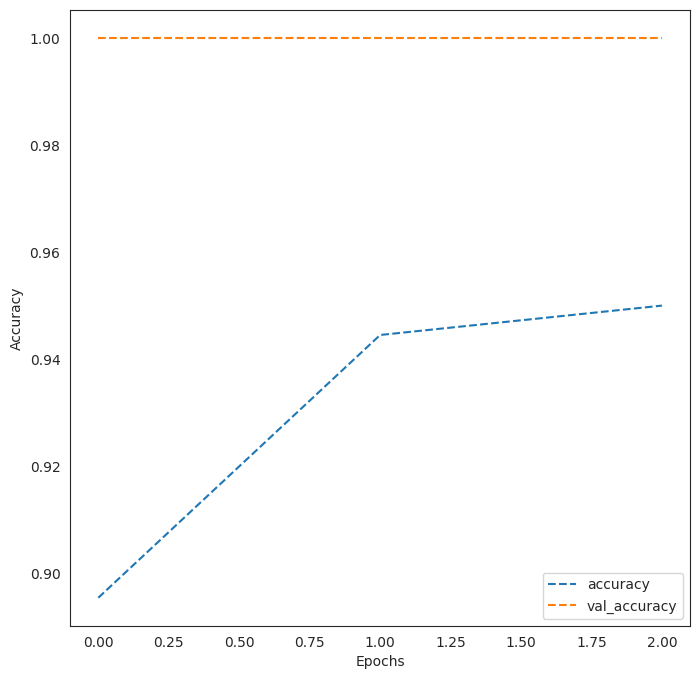

In [ ]:
# Plotting the accuracies

dict_hist = model_history.history

list_ep = [i for i in range(0, 3)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

82/82 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1300
           1       0.00      0.00      0.00      1300

    accuracy                           0.50      2600
   macro avg       0.25      0.50      0.33      2600
weighted avg       0.25      0.50      0.33      2600



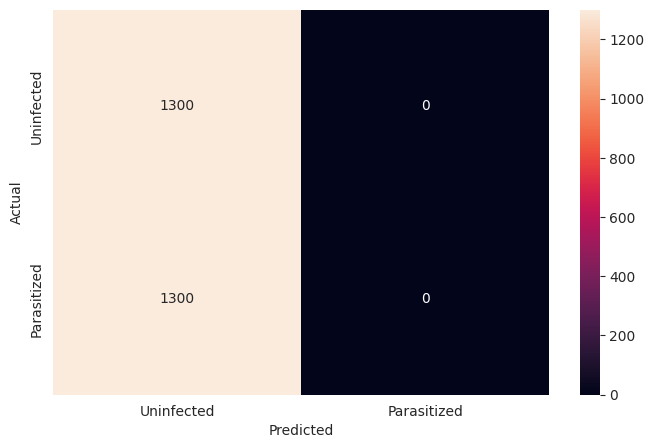

In [ ]:
# Plot the confusion matrix and generate a classification report for the model
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model5.predict(test_images)

pred = np.argmax(pred, axis = 1)

y_true = test_labels

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix

cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

###<b>Think about it:</b>
*  What observations and insights can be drawn from the confusion matrix and classification report?
*  Choose the model with the best accuracy scores from all the above models and save it as a final model.


####<b> Observations and Conclusions drawn from the final model: </b>

- The 1st cnn model (model) predicted infected and uninfected models accurately
- Report shows that model1-5 were unable to correctly determine parasitized samples
- There must be an imbalance in the data that was not determined, this would require further analysis of images and labels


**Improvements that can be done:**<br>


*  Can the model performance be improved using other pre-trained models or different CNN architecture?
*  You can try to build a model using these HSV images and compare them with your other models.

#### **Insights**

####**Refined insights**:
What are the most meaningful insights from the data relevant to the problem?

- model was the best model
- Labels appear to be balance between parasitized and uninfected
-success with later average of uninfected and parasitized images

####**Comparison of various techniques and their relative performance**:
How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

- model performed the best
- Various later techniques, from model0 did not perform well because of a possible data imbalance

####**Proposal for the final solution design**:
What model do you propose to be adopted? Why is this the best solution to adopt?

- Would  recommend model; high accuracy, and precision. Predicted infcted and uninfected RBcs very well